# Supplementary Figure 7

**Summary:**<br>

- **Panel a:** Single SL1 promotor - nlp-36 (B0464.3)

- **Panel b:** Multiple SL1 promotors - M60.4

- **Panel c:** Operon organization - rla-1 (Y37E3.8) & Y37E3.7

- **Panel d:** Differentially trans-spliced promoters - lev-11 (Y105E8B.1)

---
<br>



## Import libraries

In [1]:
import pandas as pd
import numpy as np
import pyfastx
import re

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoLocator

from dna_features_viewer import GraphicFeature, GraphicRecord

## Settings for saving figures as pdf

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set environmental constants

In [3]:
# Set path where files are stored
path = '/Volumes/elegans/rna_sequencing'

In [4]:
runs = ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6', 'SL1_1', 'NP_1', 'NP_2', 'NP_3', 'NP_4', 'NP_5']

## Opening Dataset file

In [5]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv(f'{path}/dataset_+SSP+SL+HAIRPIN.tsv', sep='\t')

In [6]:
genes_start = pd.read_csv(f'{path}/start_positions_stats.tsv', sep='\t')

---

<br>

# Functions

In [7]:
## transcript length
transcript_length = {}
for transcript, seq, _ in pyfastx.Fastx(f'{path}/ref/c_elegans.PRJNA13758.WS270.mRNA_transcripts.fa'):
    transcript_length[transcript] = len(seq)

In [8]:
# Helper function
# Prevents from drawing exons that overlaps

def OverlappingExons(start, end, exon):
    x, y = exon
    if x <= start <= y or x <= end <= y:
        return False
    else:
        return True

In [9]:
def plot_isoform_structure(isoform, return_coordinates=False):
    
    # Open reference files
    exonslist = pd.read_csv(f'{path}/ref/exon_coordinates_full.txt', sep='\t')

    # Select exons for gene of interest and remove duplicates
    exonslist = exonslist.loc[(exonslist['Transcript stable ID'] == isoform)&(exonslist['cDNA coding start'].notna())].sort_values('Exon rank in transcript')

    # Process exons
    exons_set = []
    gene_structure = []

    for _, exon in exonslist.iterrows():
        start = exon['cDNA coding start']
        end = exon['cDNA coding end']
        set_size = len(exons_set)

        if set_size == 0:
            exons_set.append((start, end))
        else:
            if all([OverlappingExons(start, end, exons_set[n]) for n in range(set_size)]):
                exons_set.append((start, end))

    color = {1: '#ffd1df', -1: '#95d0fc'}
    strand = exonslist['Strand'].unique()[0]

    for i, exon in enumerate(exons_set, 1):
        start, end = exon
        if i == len(exons_set):
            strd = +1
        else:
            strd = 0

        gene_structure.append(GraphicFeature(start=start, end=end, strand=strd, color=color[strand]))

    # Calculate isoform length
    length = transcript_length[isoform]
    
    # Create feature to be plotted
    record = GraphicRecord(first_index=0, sequence_length=length, features=gene_structure)
    
    if return_coordinates is False:
        return record
    else:
        return (0, length), record

In [10]:
def plot_with_isoform_structure(gene, dataframe, savefig=False):
    
    %matplotlib inline
    sns.set_style("ticks")
    
    # get common name 
    #name = f'{refname[gene]} ({gene})' if refname[gene] == refname[gene] else gene
    
    # table pre-processing
    sorting_col = ['isoform', 'transcriptomic_start', 'SC5']
    table = dataframe[dataframe['gene']==gene].sort_values(sorting_col, ascending=False).reset_index(drop=True)
    
    
    # loop over isoforms (one separe plot each)
    for isoform, isoform_table in table.groupby('isoform'):
        
        isoform_table = isoform_table.reset_index(drop=True)
        
        # Determine plot size ----------------
        total_reads = len(isoform_table)
        
        if total_reads > 2500:
            isoform_table = isoform_table.sample(n=2500).sort_values(sorting_col, ascending=False).reset_index(drop=True)
            total_reads = 2500
            
        ysize = total_reads/100
        ysize = 0.25 if ysize < 1 else ysize
        tot_size = 1 + ysize
        
        # plot setting -----------------------
        fig = plt.figure(figsize=(20, tot_size), dpi=120) # constrained_layout=True
        grid = fig.add_gridspec(2, 1, height_ratios=[1, ysize], top=1.05, bottom=0.08, right=0.95, left=0.08, hspace=0.01, wspace=0)

        # Gene structure ----------------------
        axis1 = fig.add_subplot(grid[0])
        axis1.grid(False)
        axis1.axis('off')
        (transcript_start, transcript_end), record = plot_isoform_structure(isoform, return_coordinates=True)
        record.plot(ax=axis1)
        axis1.text(0, 1, isoform, horizontalalignment='left', verticalalignment='center', weight='bold', size=12)


        # Read features ----------------------
        axis2 = fig.add_subplot(grid[1], sharex=axis1)
        start_positions = []
        end_positions = []
        
        for idx, row in isoform_table.iterrows():
        
            ymax = idx

            # offset transcriptomic start
            offset_value = int(row['transcriptomic_start'])

            # Read regions ( 5'SC, alignment, 3'SC ) -------------
            sc5_start = row['SC5'] + offset_value
            aln_start = offset_value 
            aln_end = row['alignment_length'] + offset_value
            sc3_end = row['SC3'] + offset_value
            
            start_positions.append(sc5_start)
            end_positions.append(sc3_end)
            
            axis2.plot([sc5_start, aln_start], [idx, idx], color='lightblue', zorder=-10, alpha=0.2, linewidth=1)
            axis2.plot([aln_start, aln_end], [idx,idx], color='grey', zorder=-10, alpha=0.4, linewidth=1)
            axis2.plot([aln_end, sc3_end], [idx, idx], color='lightpink', zorder=-10, alpha=0.2, linewidth=1)
            axis2.plot(aln_start, idx, marker='|', color='k', zorder=15, markersize=2)

            # SSP sequence ------------------------
            if row['SSP_FOUND'] == 'FOUND':
                sspcore = row['SSP_score']
                ssp_distance = int(row['SSP_dist']) + offset_value
                ssp_size = int(row['SSP_size'])
                axis2.plot([ssp_distance-ssp_size, ssp_distance], [idx, idx], color='orange', marker=None, zorder=2, linewidth=1) # #0b7cd9

            # SPLICE LEADER sequence ------------------
            if row['ROBUST_SL_FOUND'] == 'FOUND':
                sldist = int(row['SL_distance']) + offset_value
                slscore = int(row['SL_score'])
                axis2.plot([sldist-slscore, sldist], [idx, idx], color='#d40f2c', marker=None, zorder=5, linewidth=1)

            # HAIRPIN sequence ---------------------
            if row['HAIRPIN_FOUND'] == 'FOUND':

                s1_start, s1_end = row['HAIRPIN_stem1'][1:-1].split(', ')
                s1_start = int(s1_start) + offset_value
                s1_end = int(s1_end) + offset_value

                s2_start, s2_end = row['HAIRPIN_stem2'][1:-1].split(', ')
                s2_start = int(s2_start) + offset_value
                s2_end = int(s2_end) + offset_value

                axis2.plot([s1_start, s1_end], [idx, idx], color='#89e0a0', linewidth=1, zorder=0)
                axis2.plot([s1_end, s2_start],[idx, idx], color='black', linewidth=1, linestyle=(0, (1, 1)), zorder=0)
                axis2.plot([s2_start, s2_end], [idx, idx], color='#3c9152', linewidth=1, zorder=0)


        # plot settings
        axis2.set_xlabel('reference transcript bases')
        axis2.set_ylabel('reads')

        xmin = int(np.percentile(start_positions, 1))
        xmax = int(np.percentile(end_positions, 99))
        xmax = xmax if not xmax < transcript_end else transcript_end
        
        length = xmax-xmin
        axis2.set_xlim(xmin-(0.1*length), xmax+(0.1*length))
        axis2.set_ylim(-1, ymax+1)
        
        axis2.xaxis.set_major_locator(AutoLocator())
        
        if savefig:
            plt.savefig(f'SupFig7-read_features[{isoform}].png', dpi=300, bbox_inches='tight')


---

<br>

# Single SL1 promotor: nlp-36 (B0464.3)

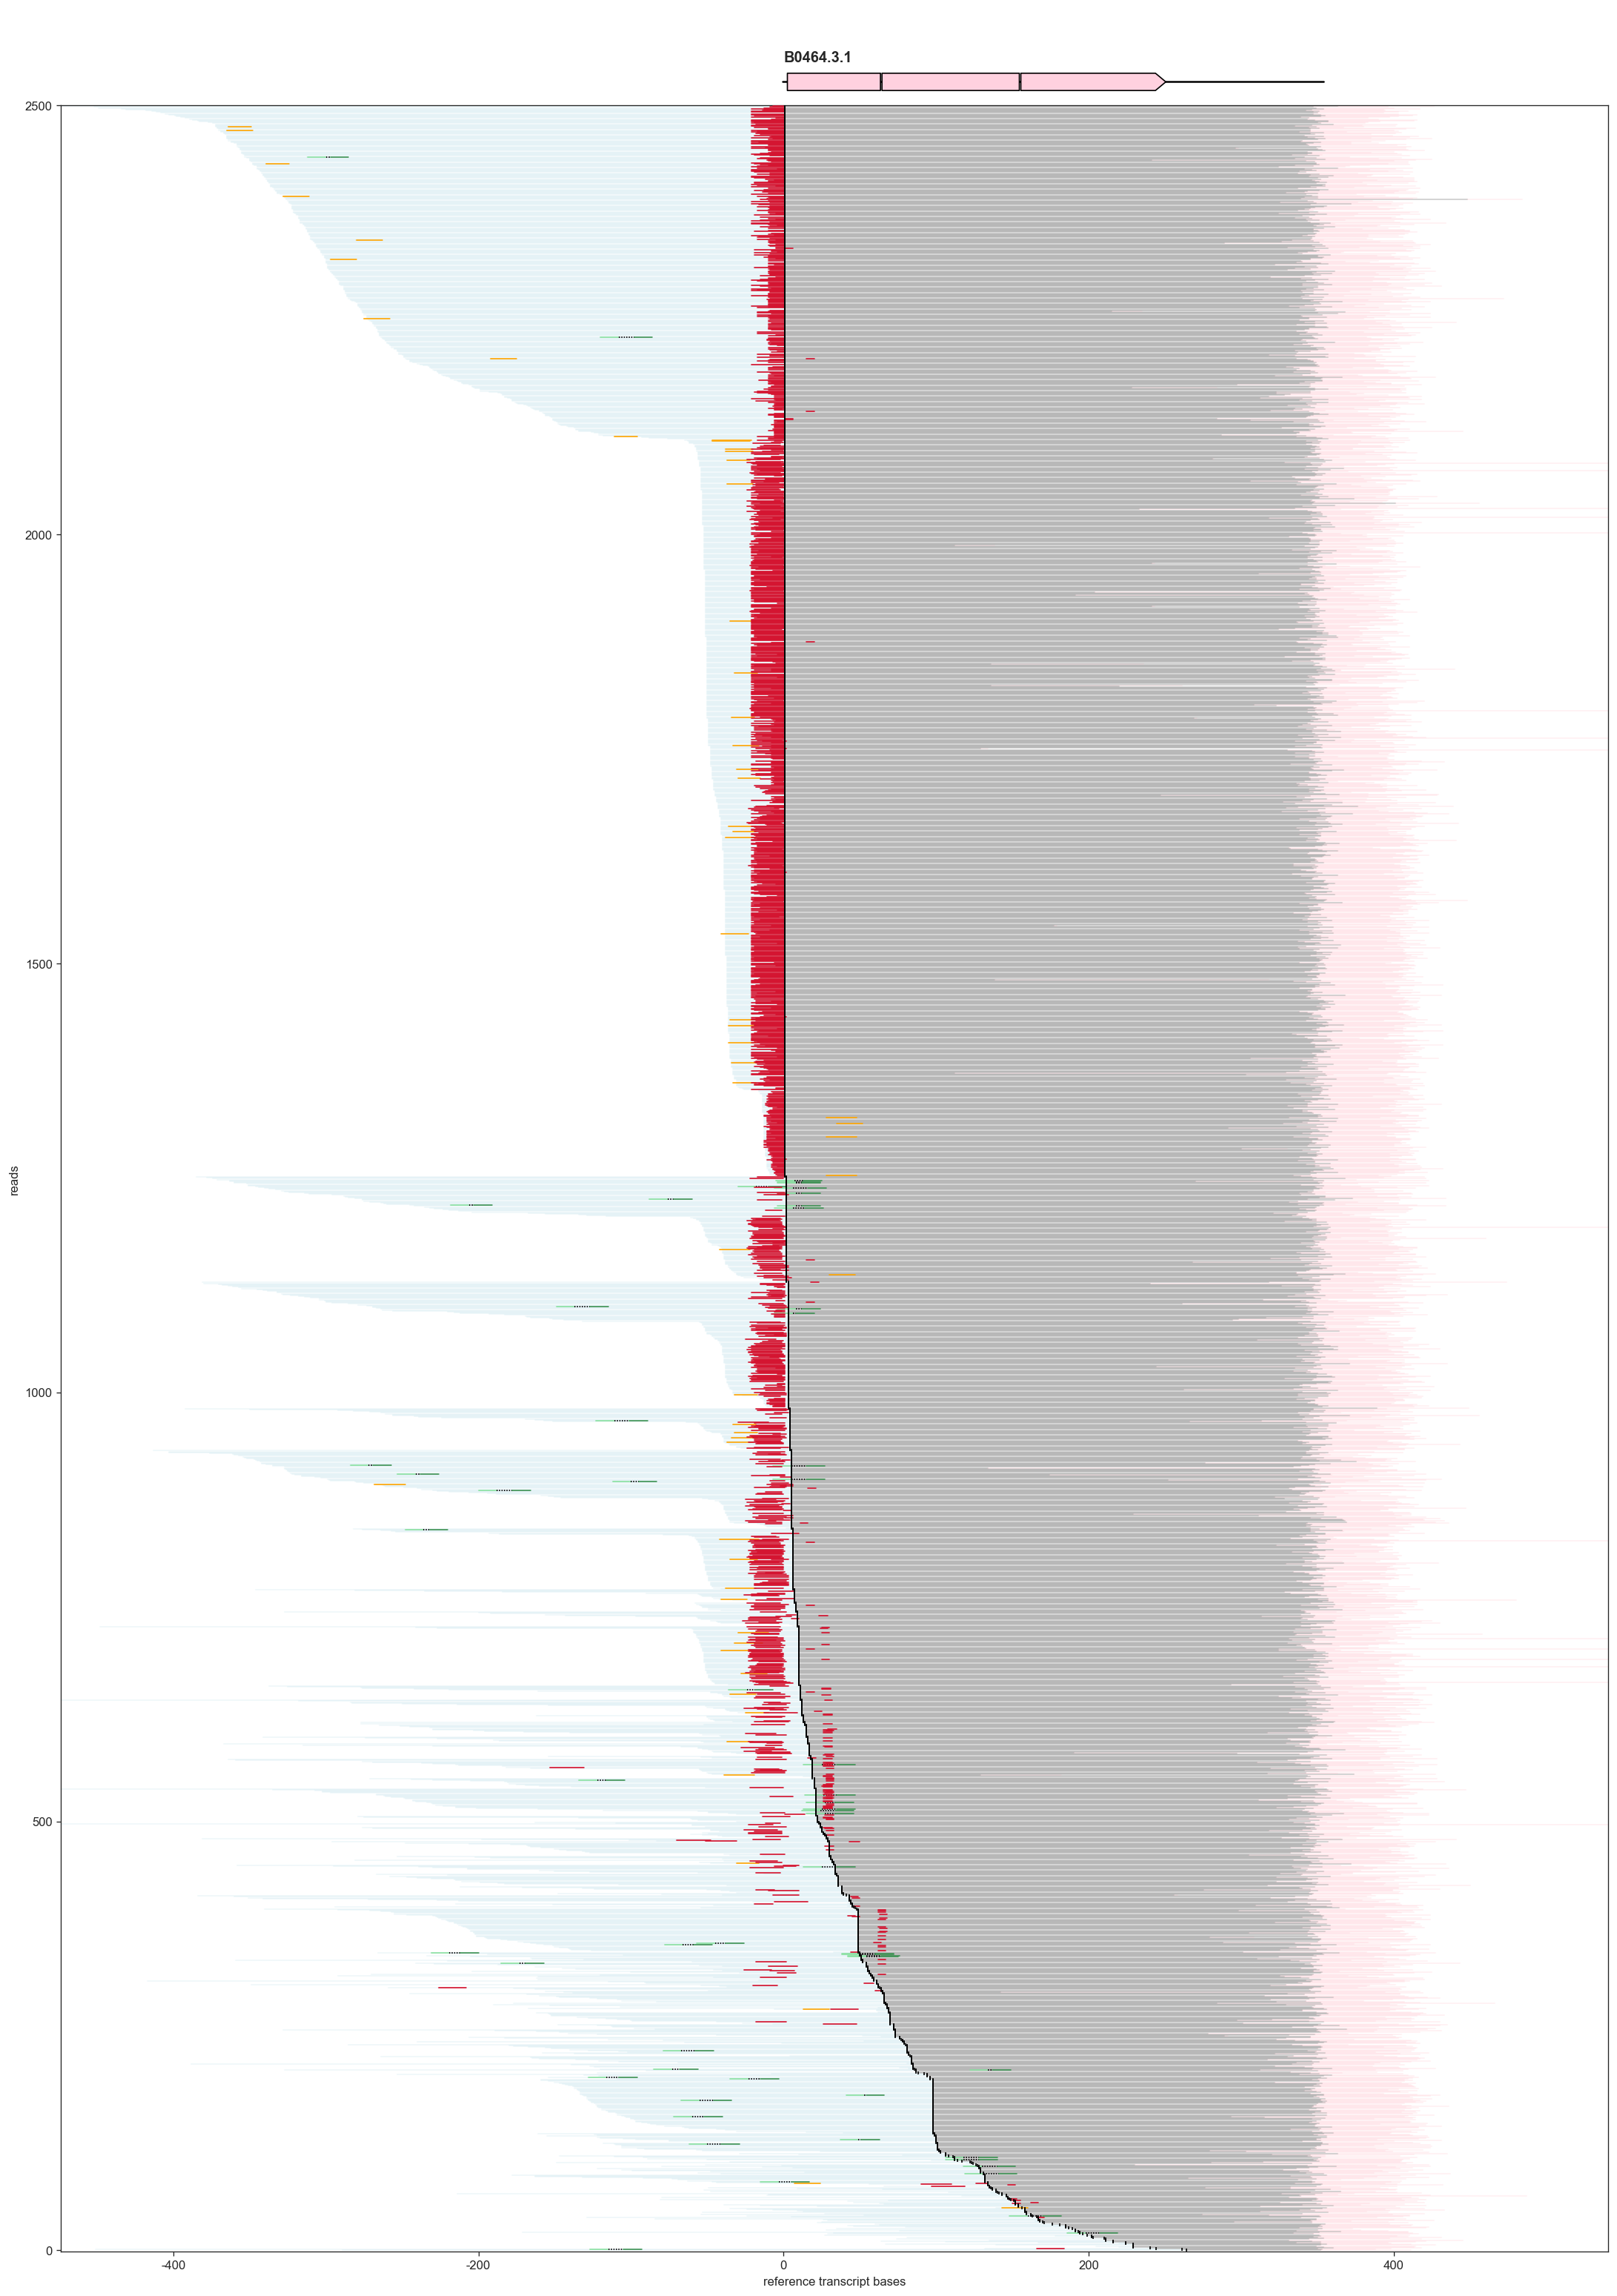

In [11]:
plot_with_isoform_structure(gene='B0464.3', dataframe=dataset, savefig=True)

<font size="4">**Supplementary Figure 7.a:**<br></font>
Expanded representation of read features identified for each annotated gene isoform.

<br>

# Multiple SL1 promotors: M60.4

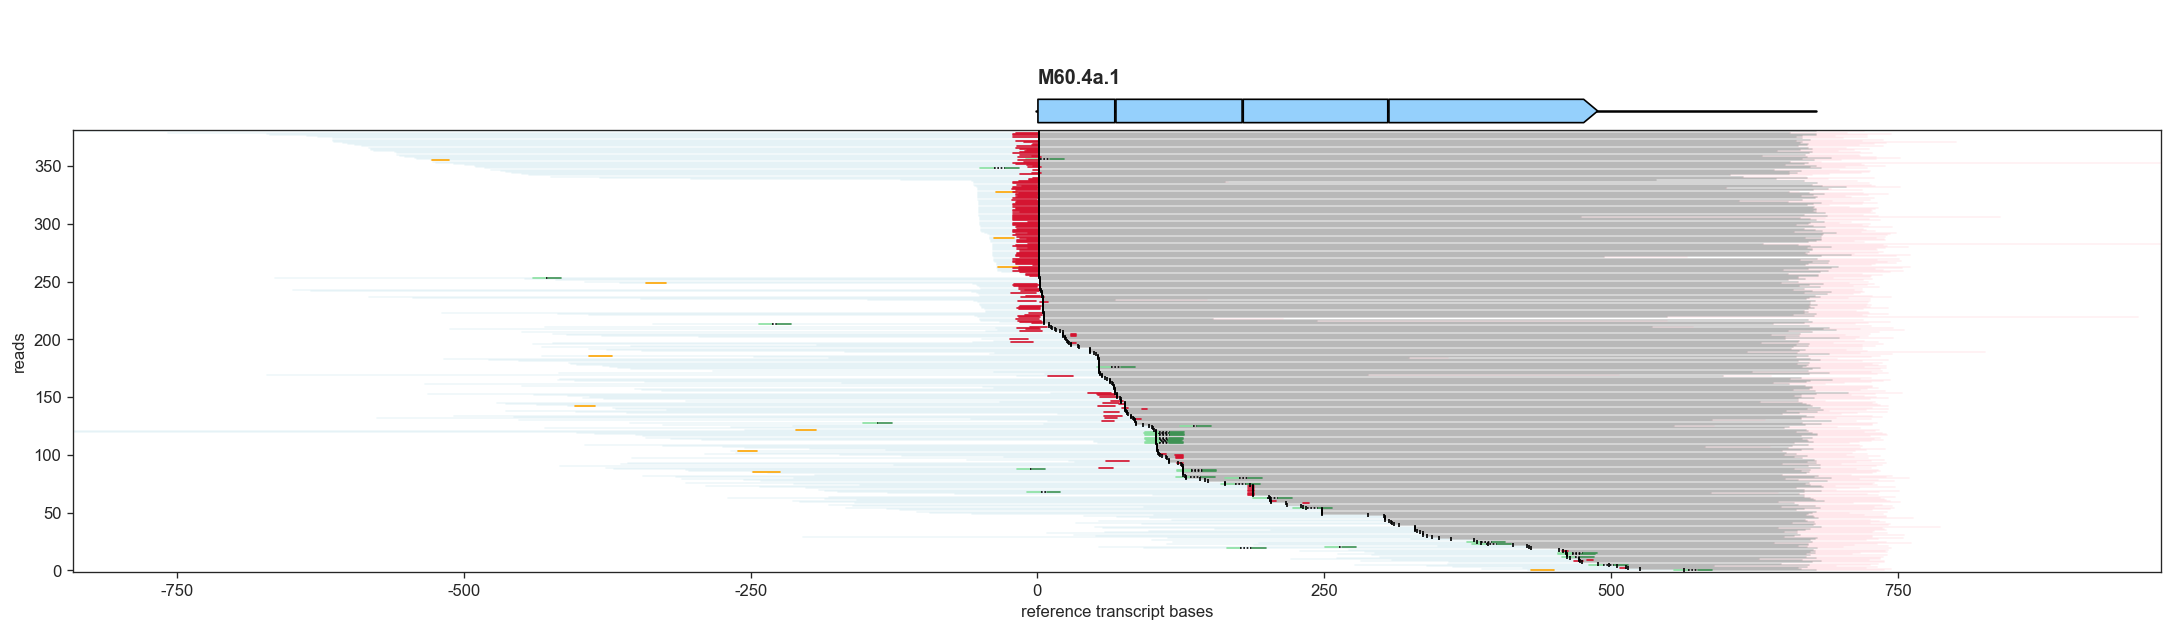

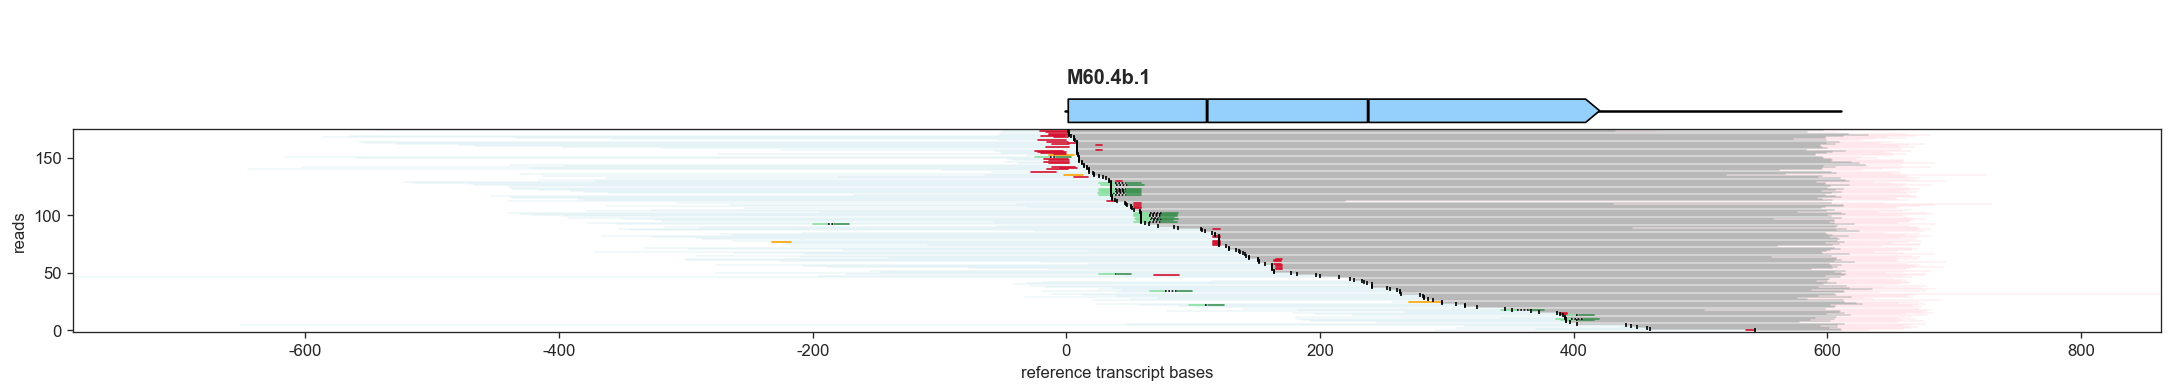

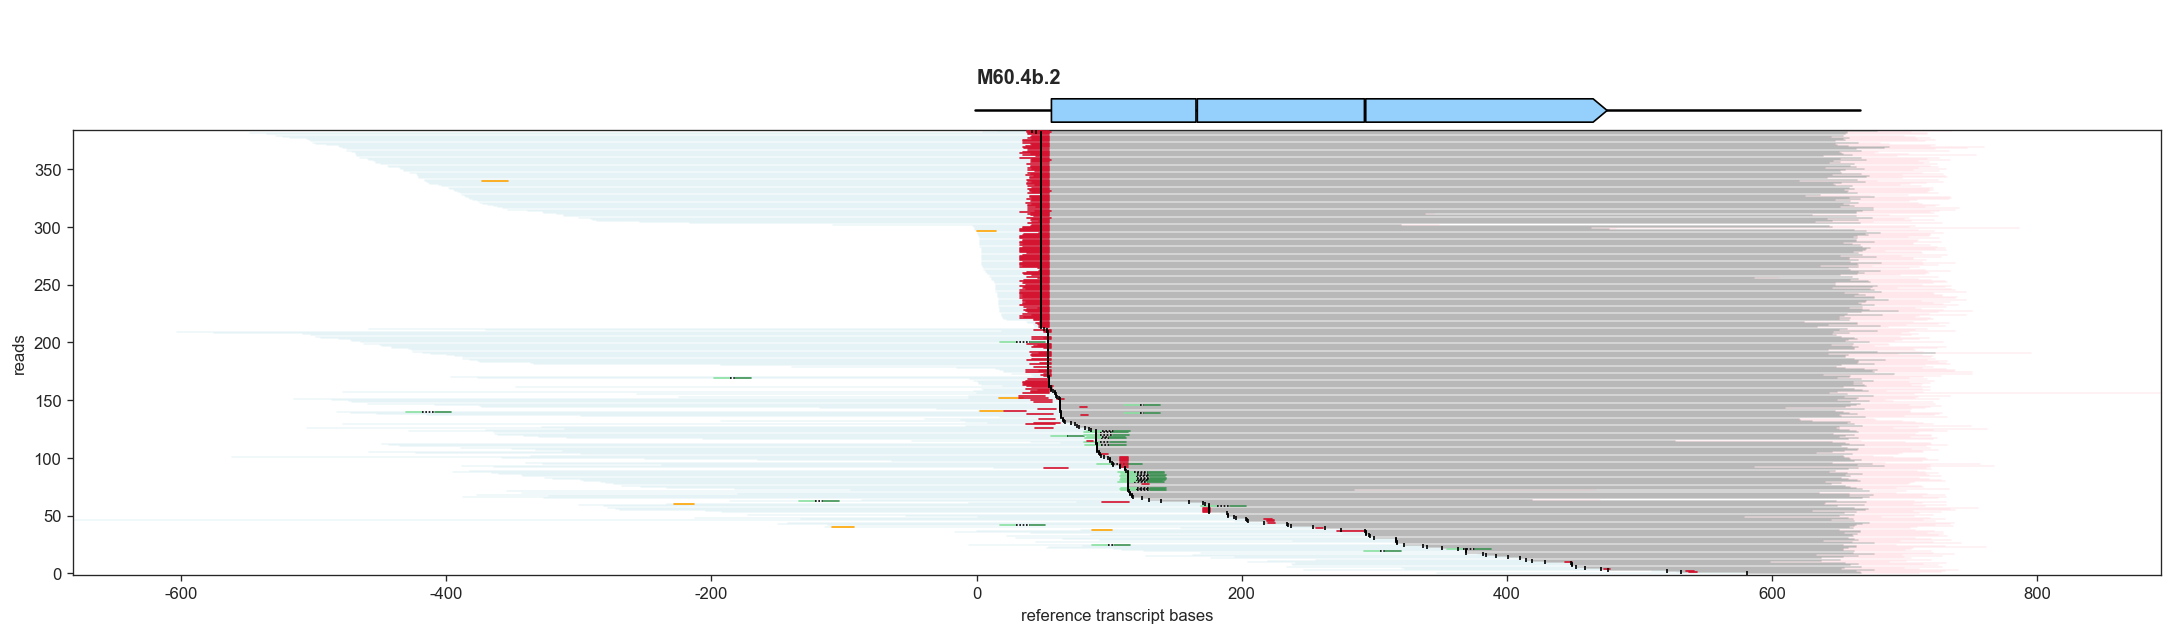

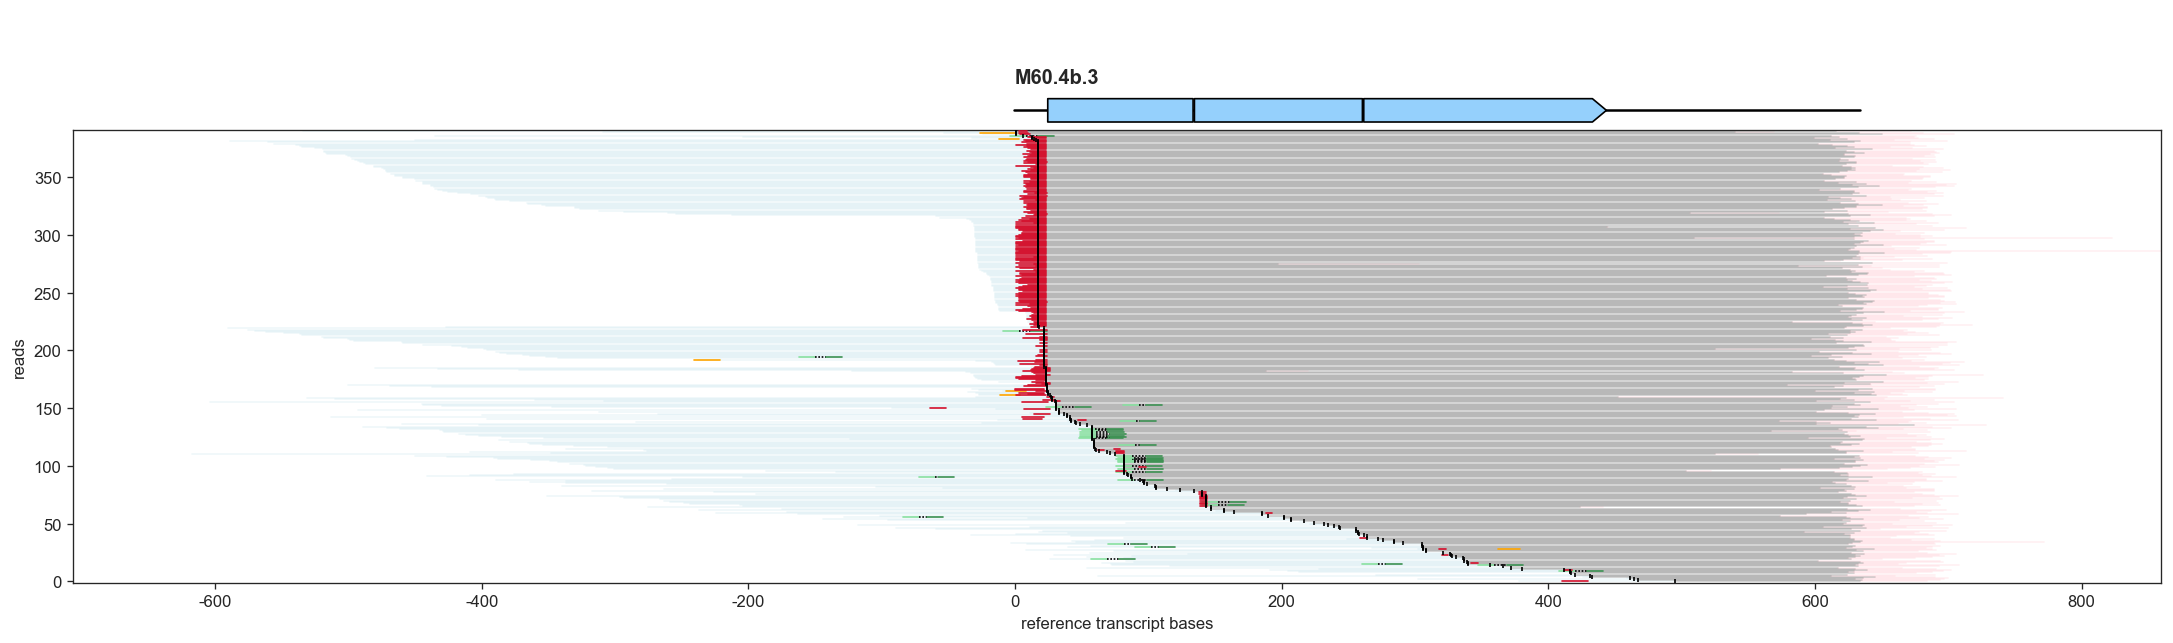

In [12]:
plot_with_isoform_structure(gene='M60.4', dataframe=dataset, savefig=True)

<font size="4">**Supplementary Figure 7.b:**<br></font>
Expanded representation of read features identified for each annotated gene isoform.

<br>

# SL1/SL2 operon: Y37E3.8 & Y37E3.7

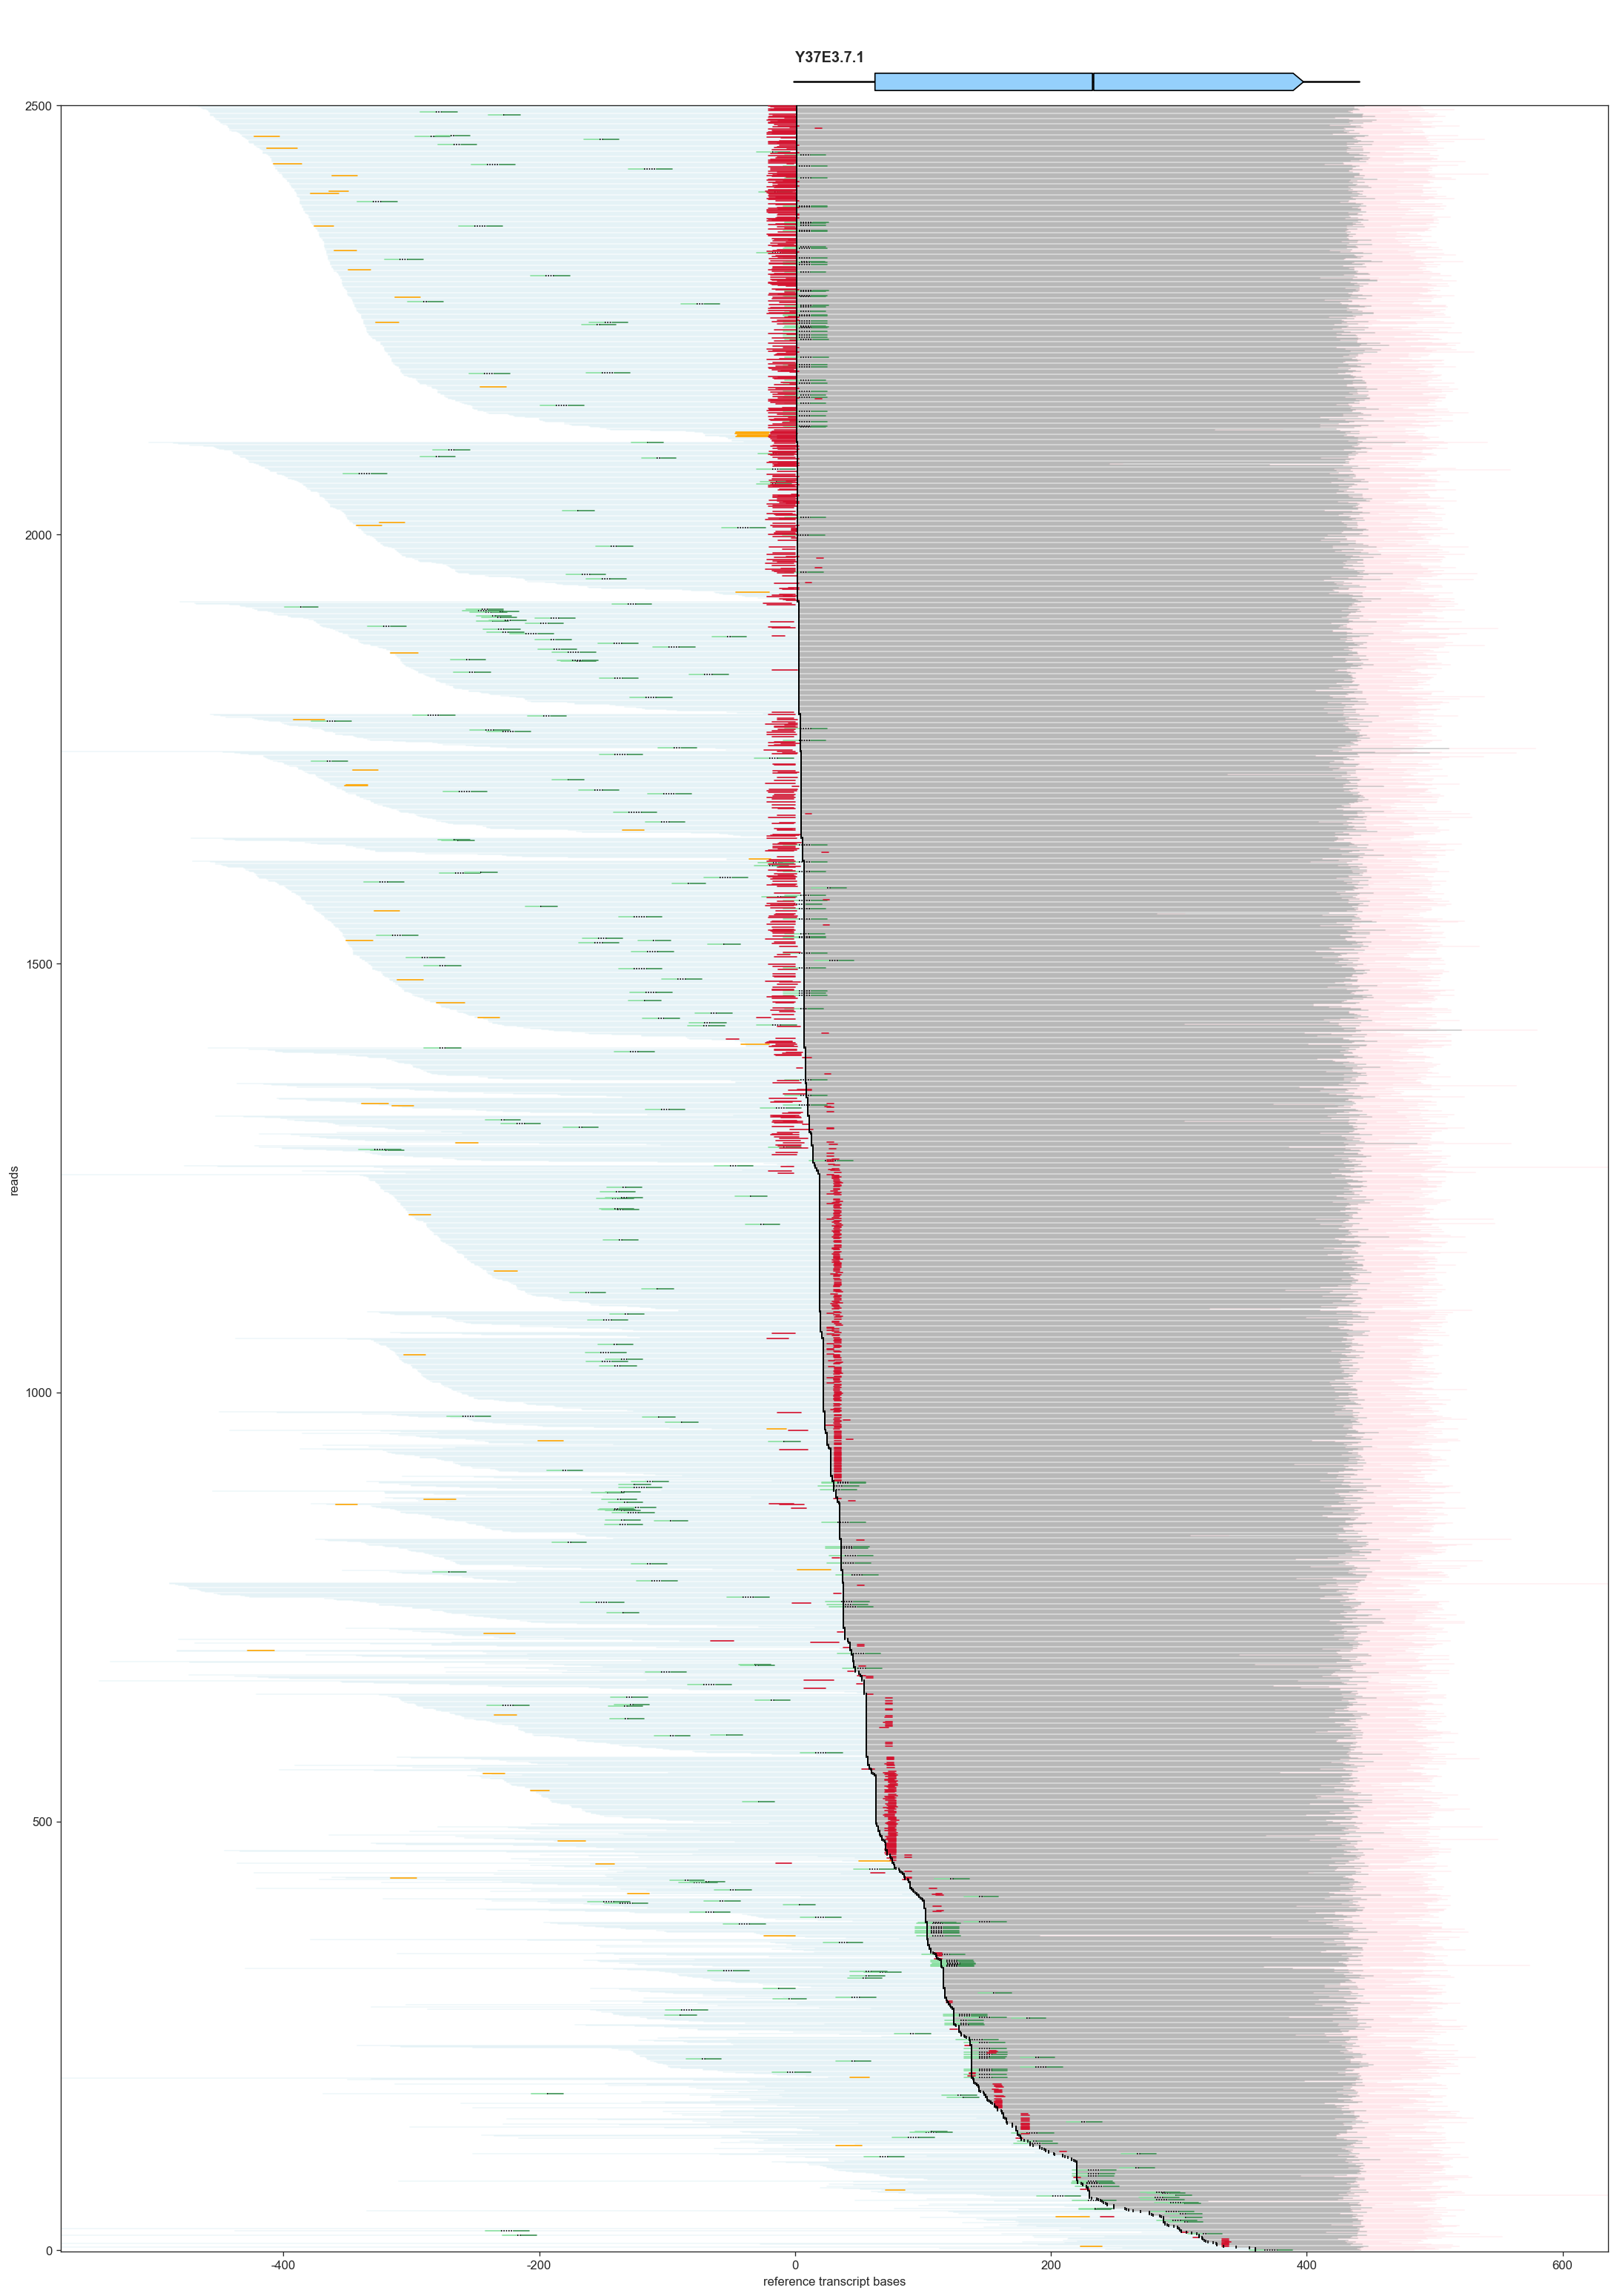

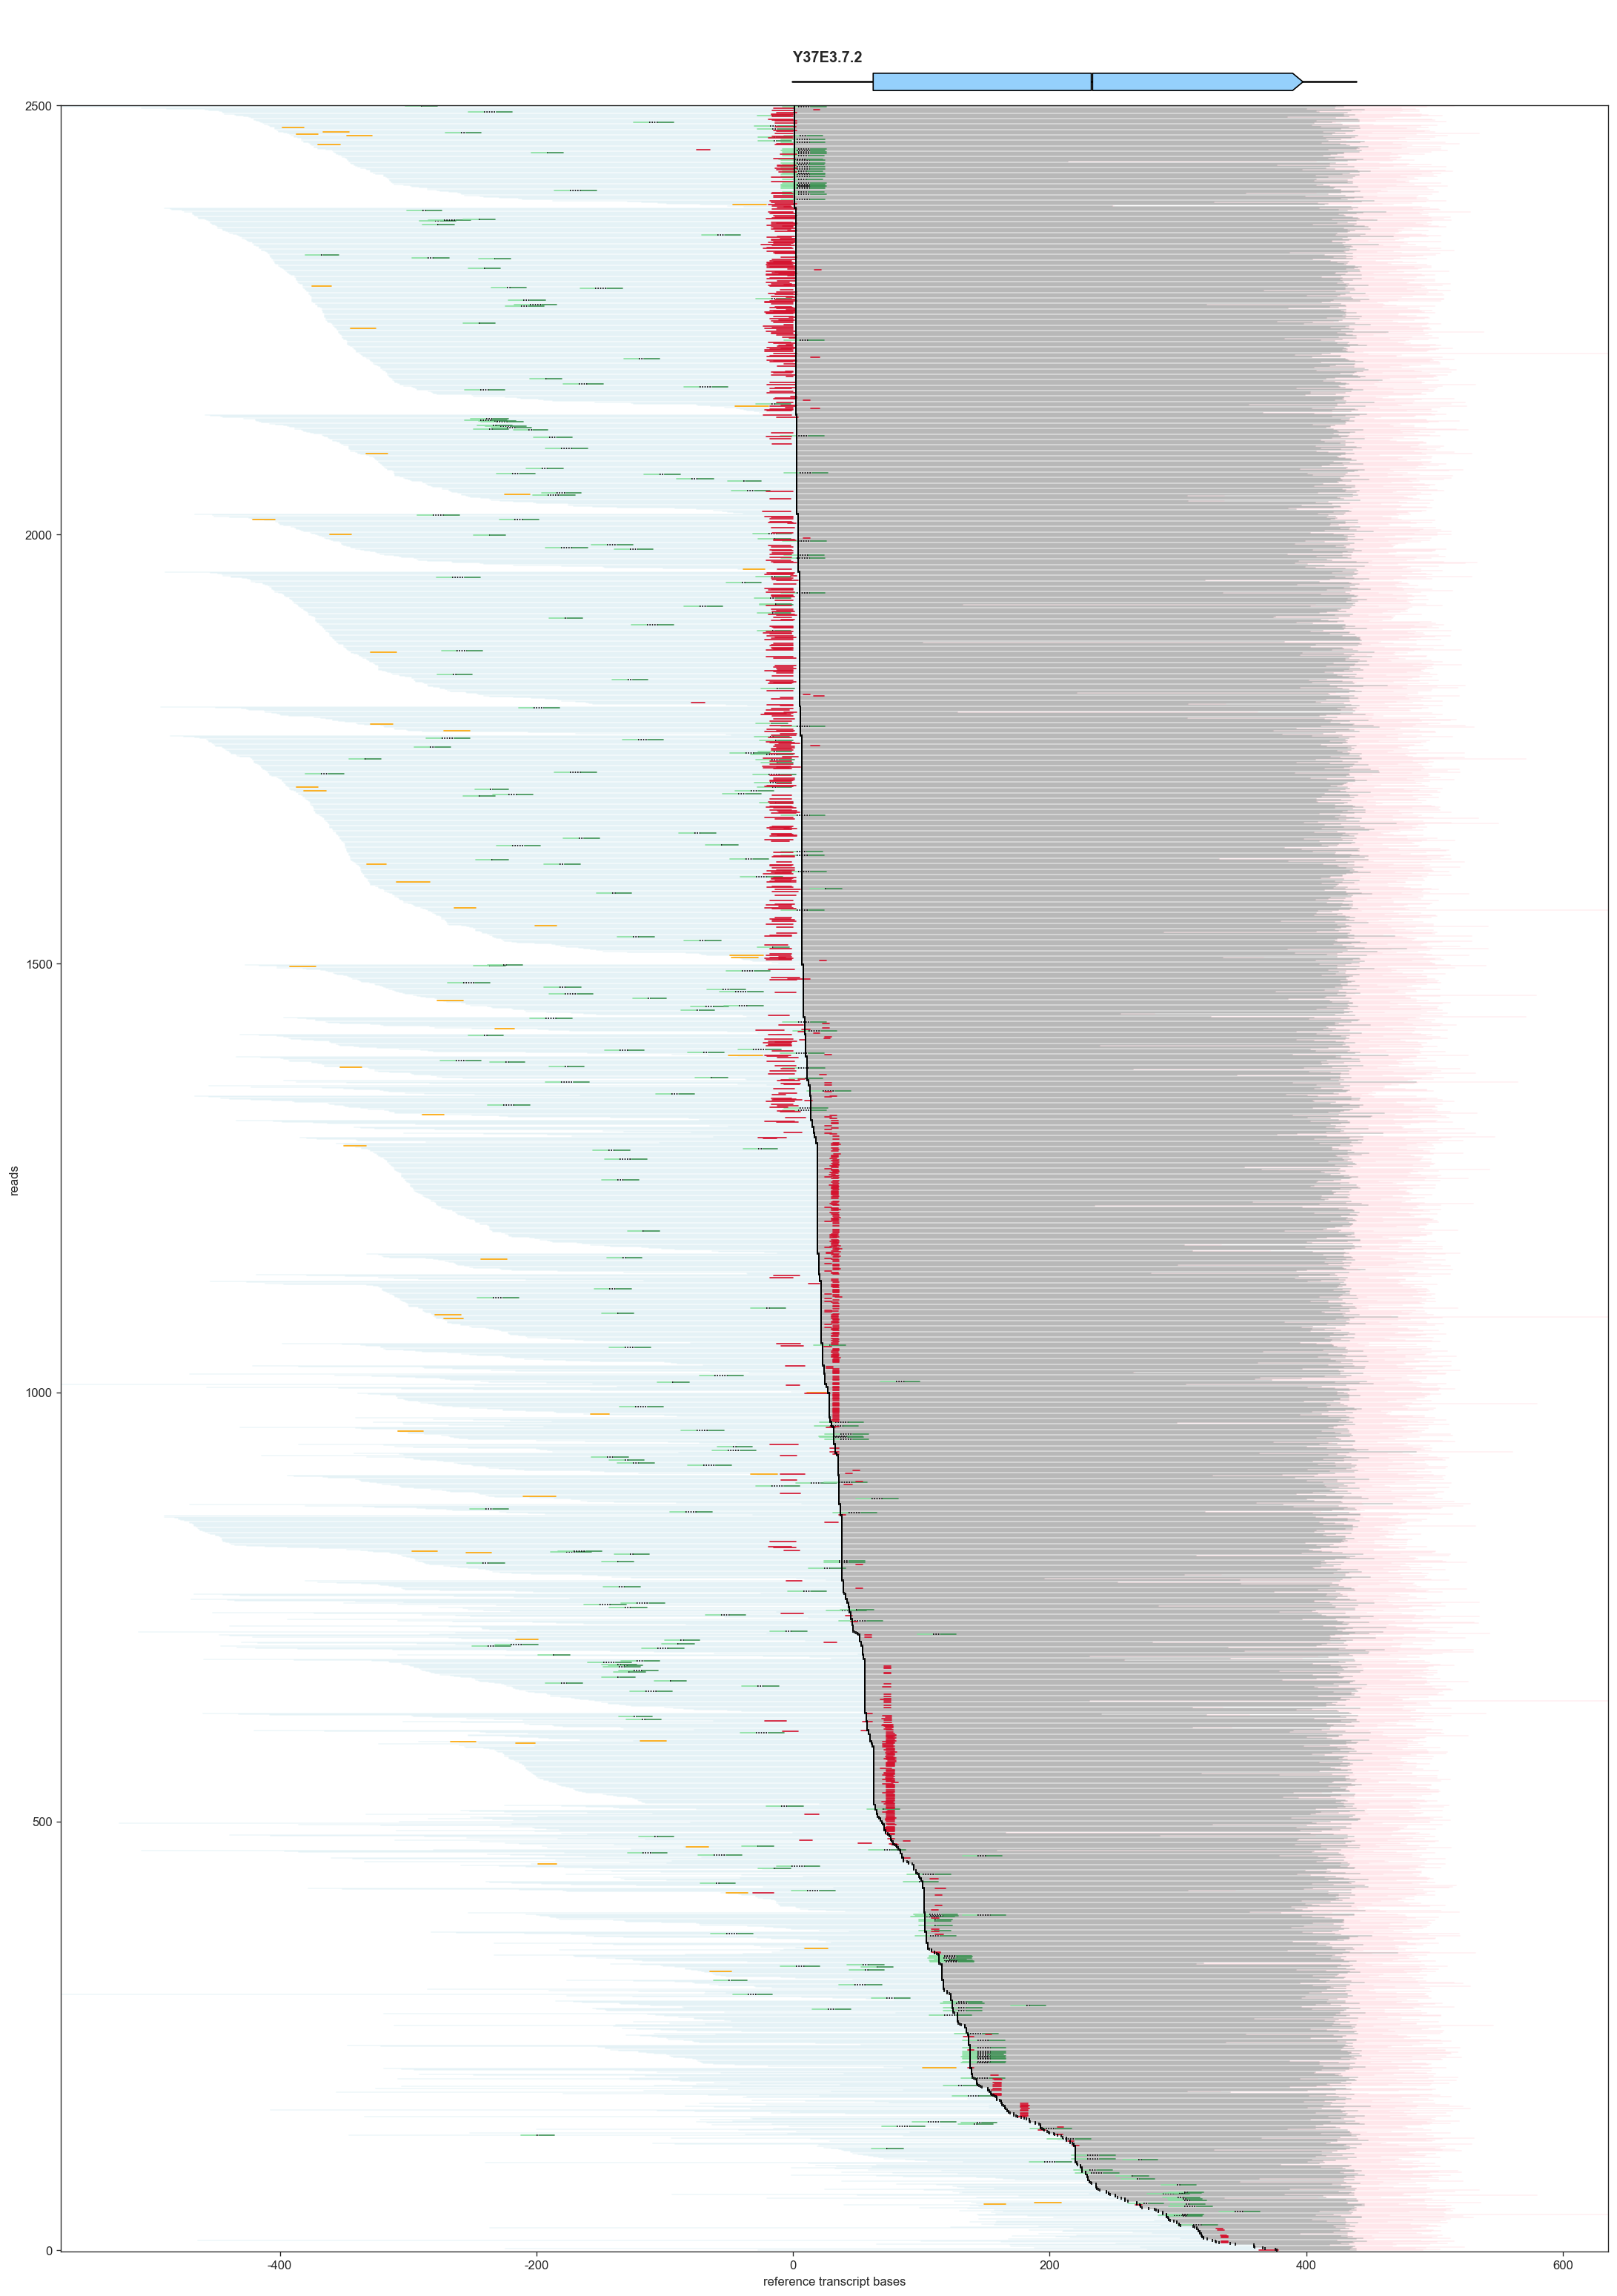

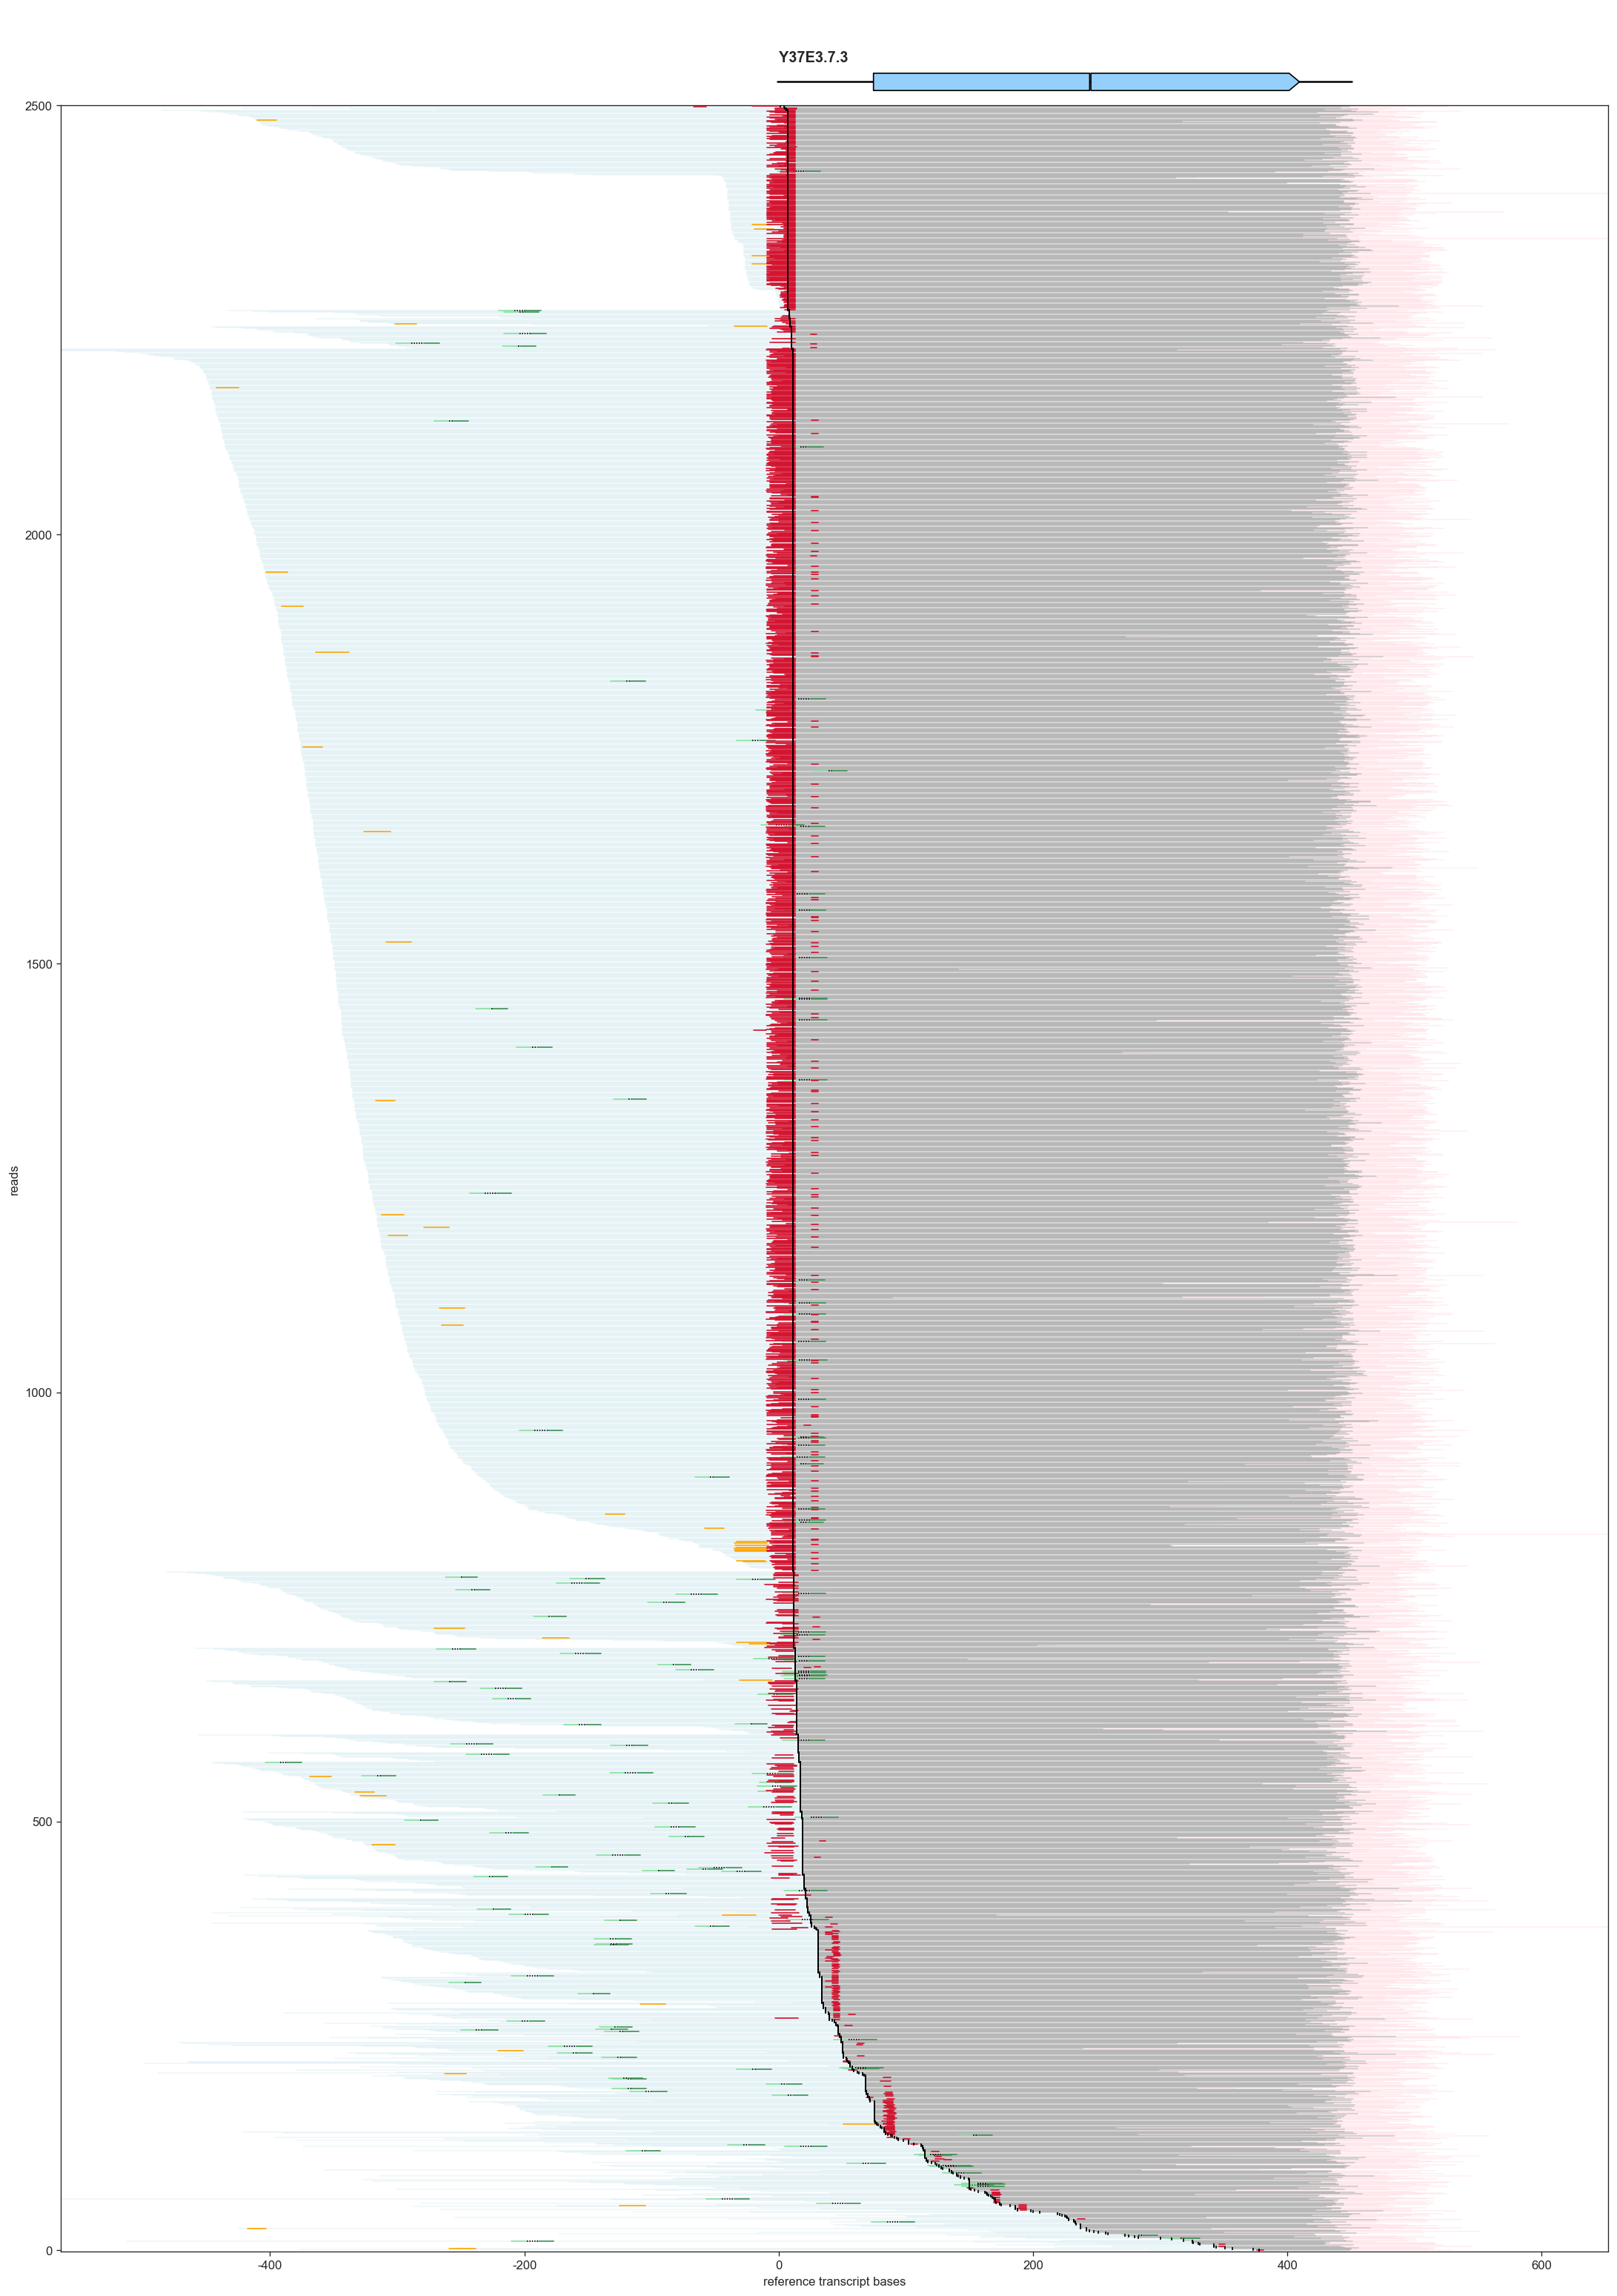

In [13]:
plot_with_isoform_structure(gene='Y37E3.8', dataframe=dataset, savefig=True)

plot_with_isoform_structure(gene='Y37E3.7', dataframe=dataset, savefig=True)

<font size="4">**Supplementary Figure 7.c:**<br></font>
Expanded representation of read features identified for each annotated gene isoform.

<br>

# Multiple trans-splicing: lev-11 (Y105E8B.1)

/Users/florianbrnrd/opt/miniconda3/envs/elegans_transplicing/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


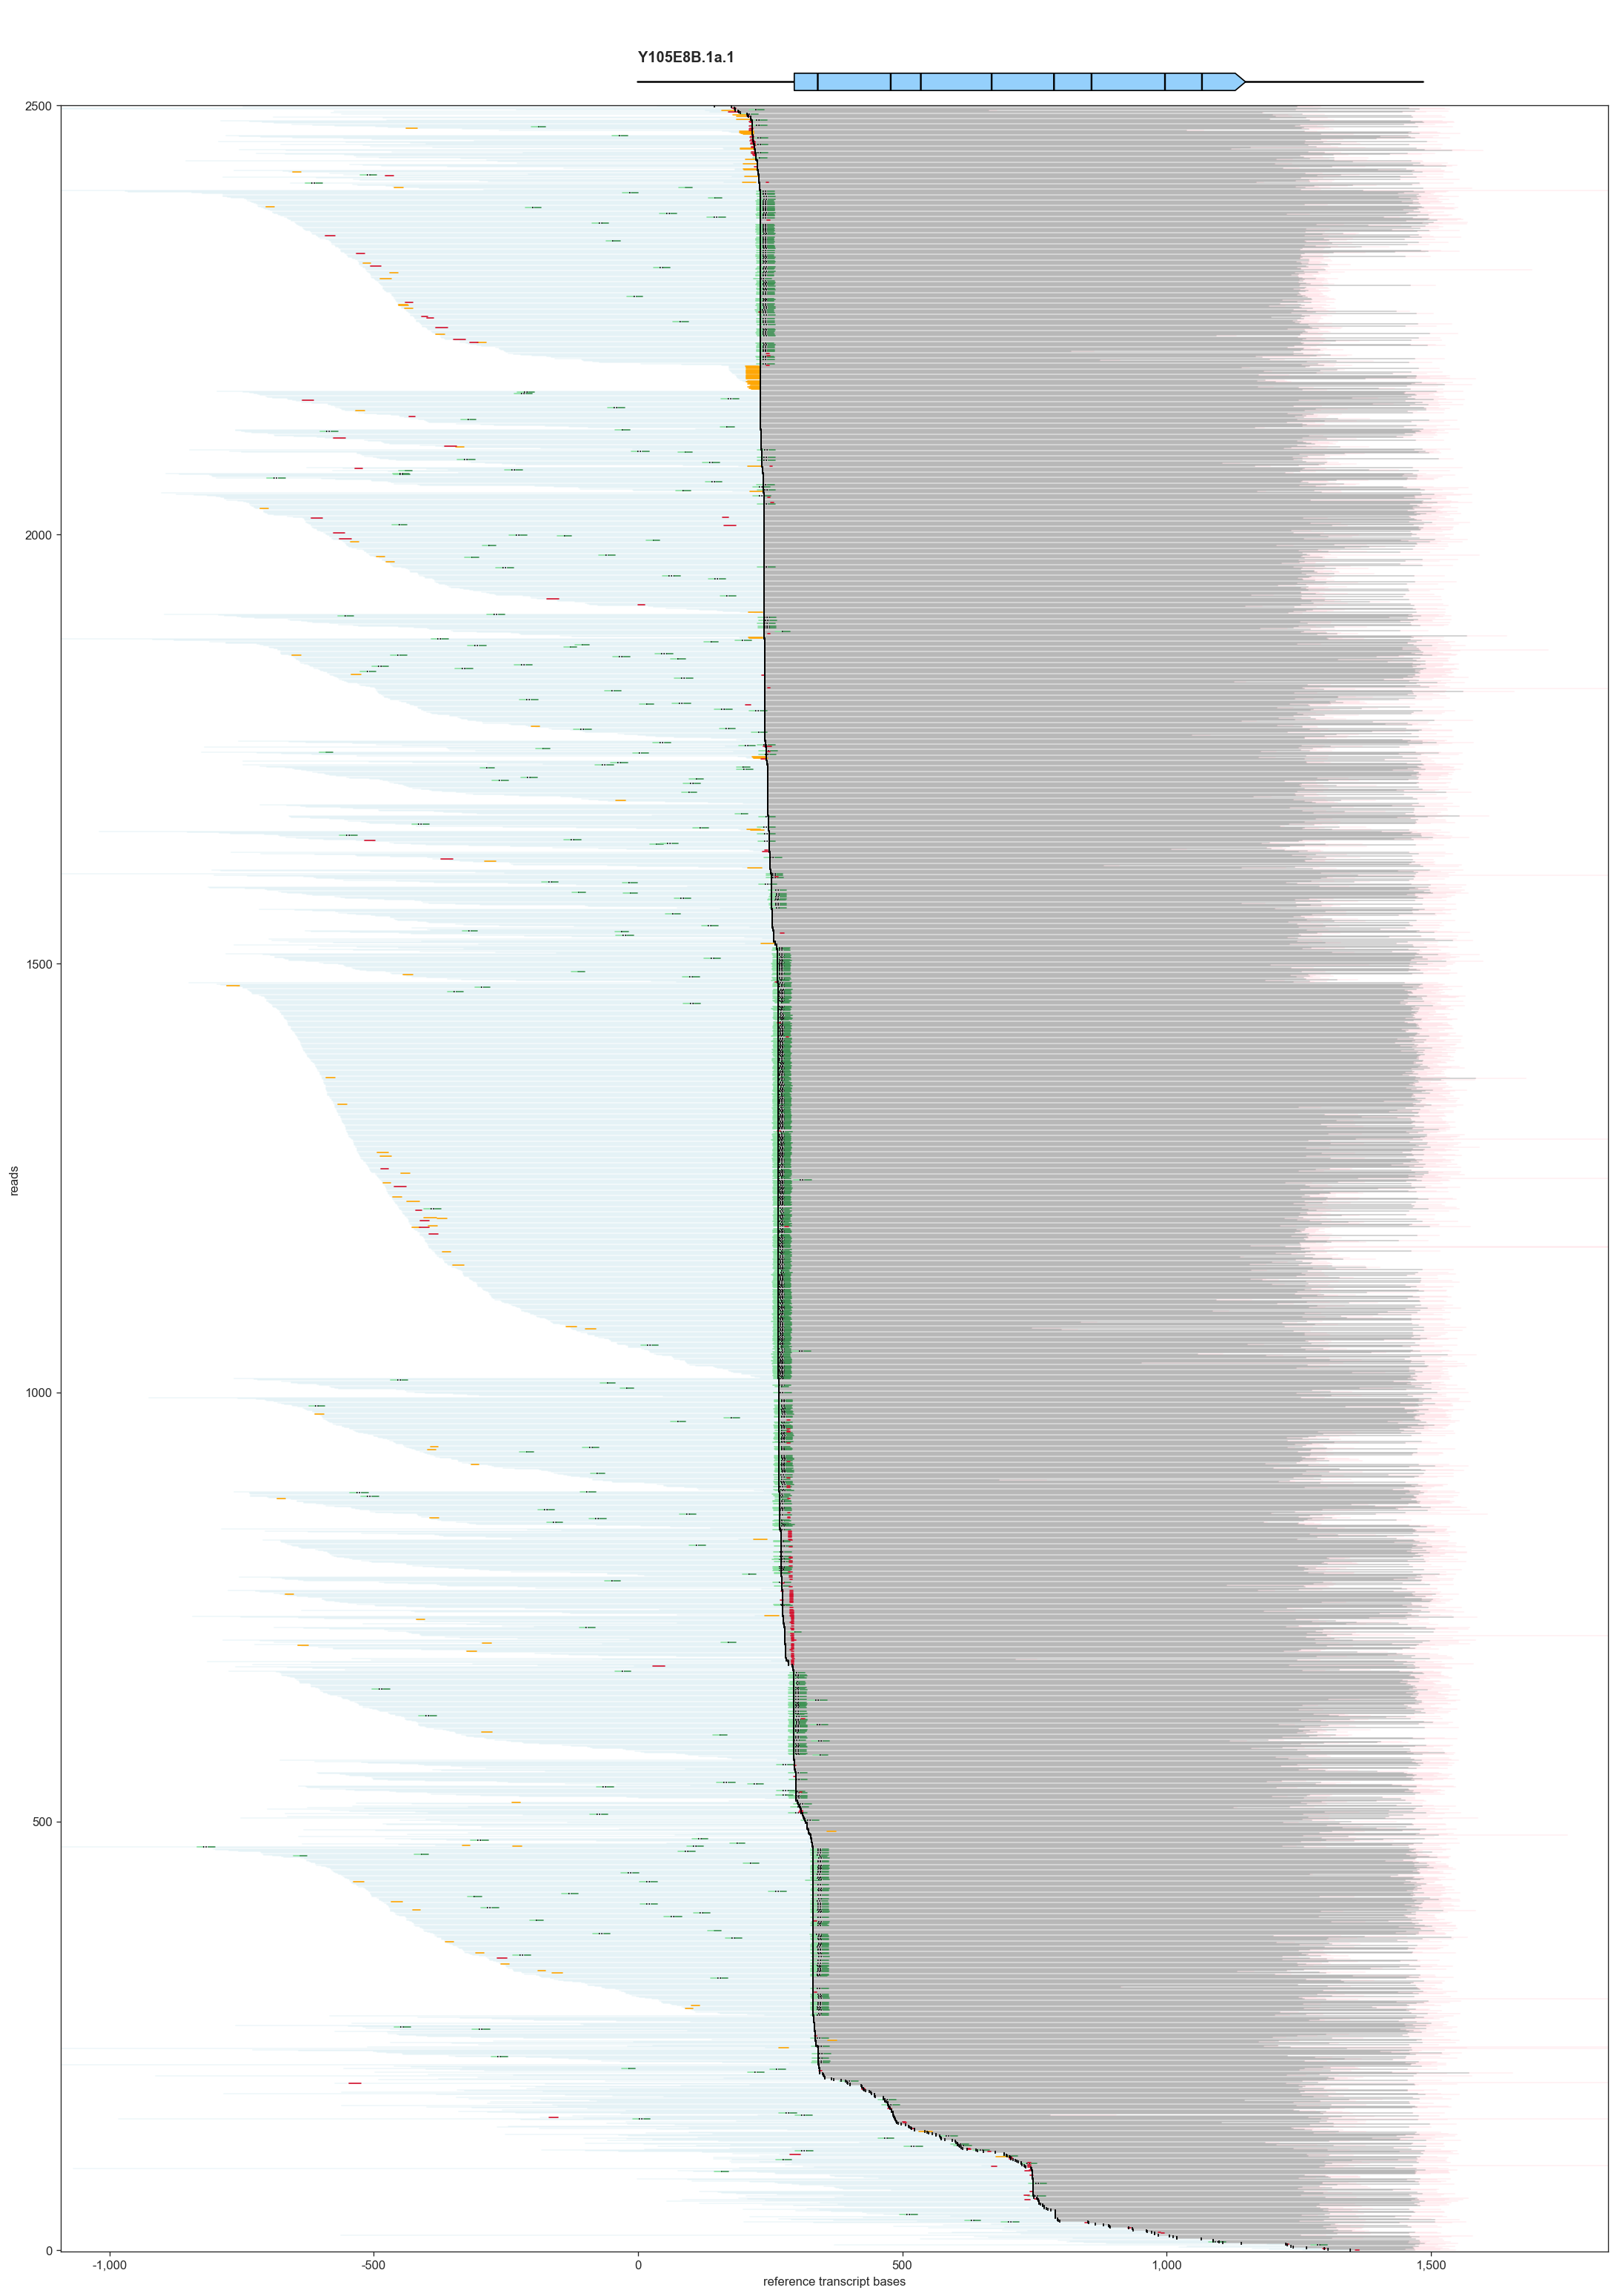

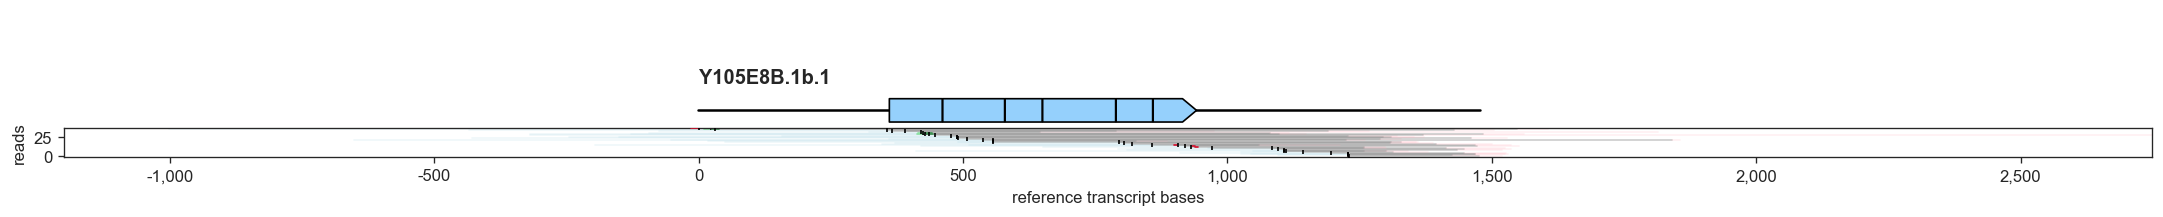

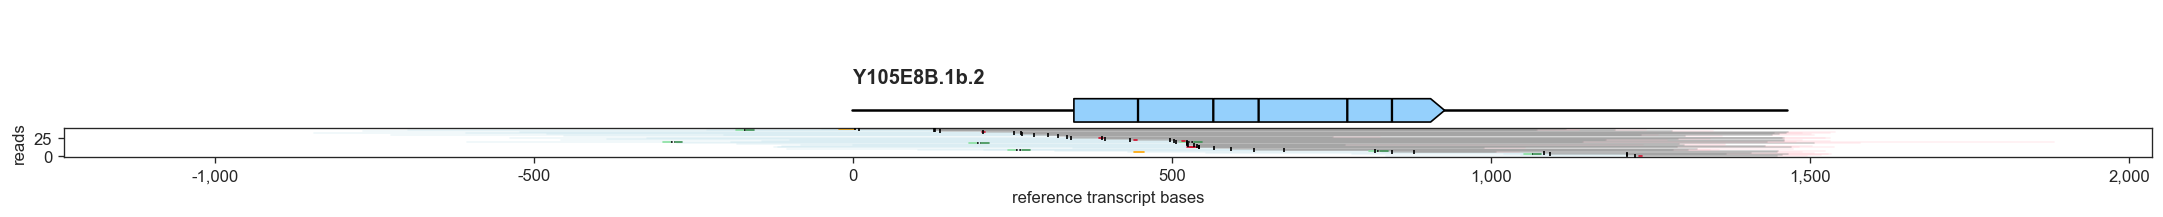

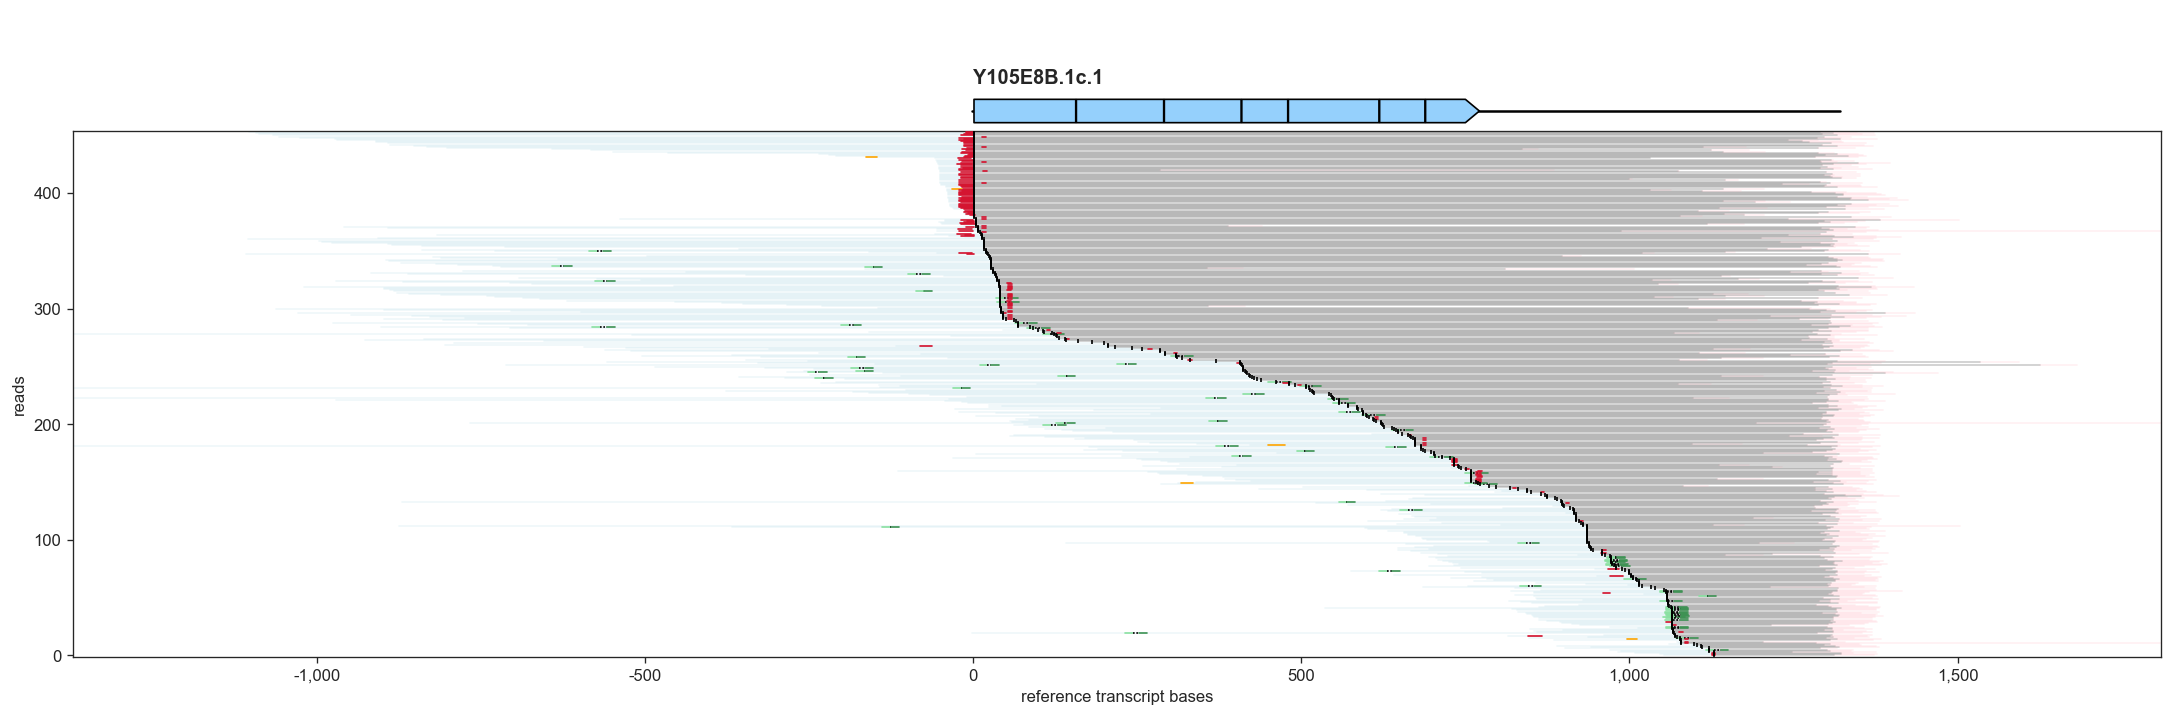

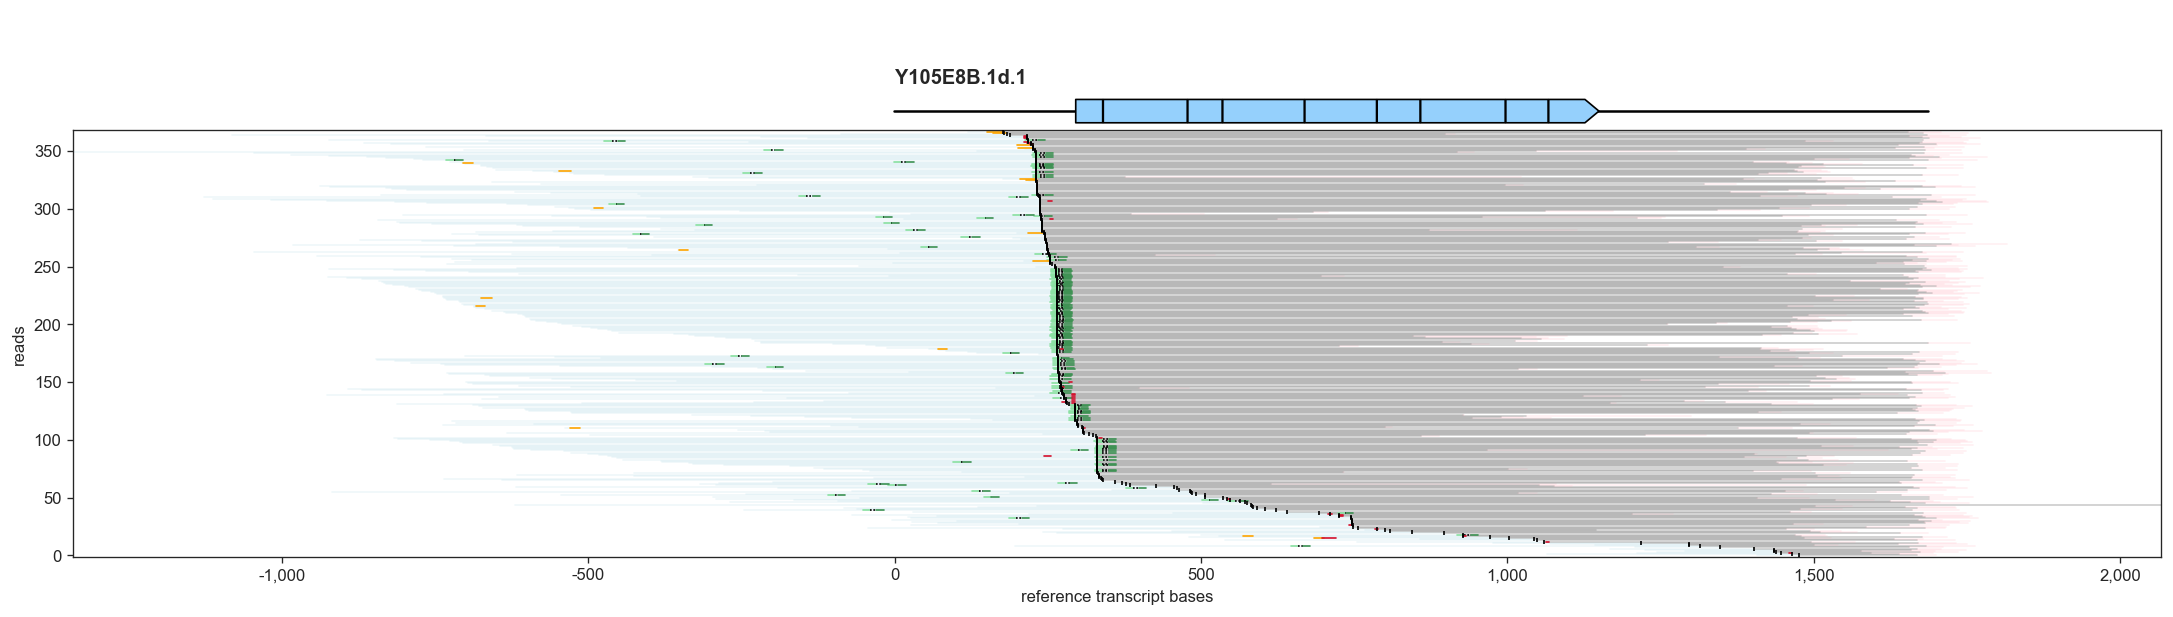

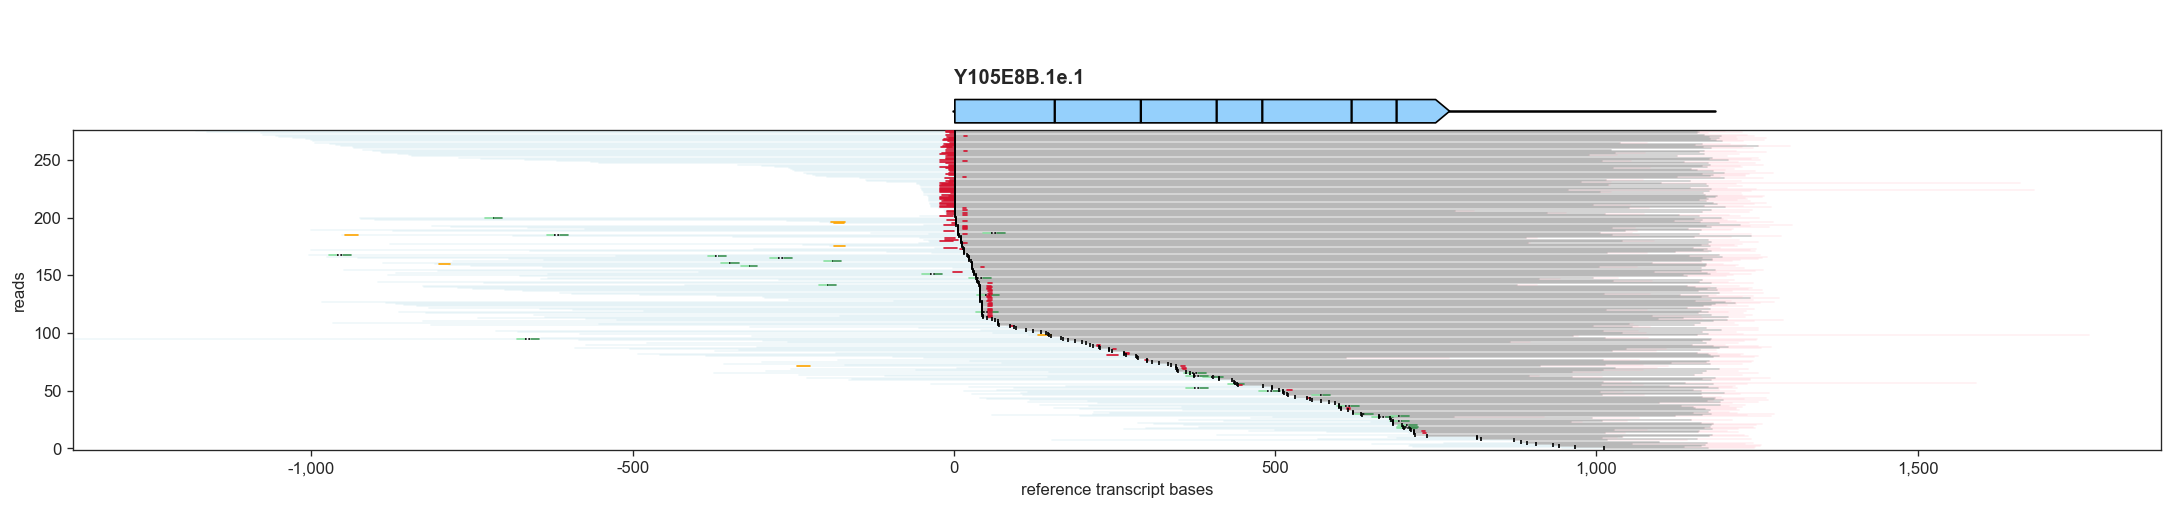

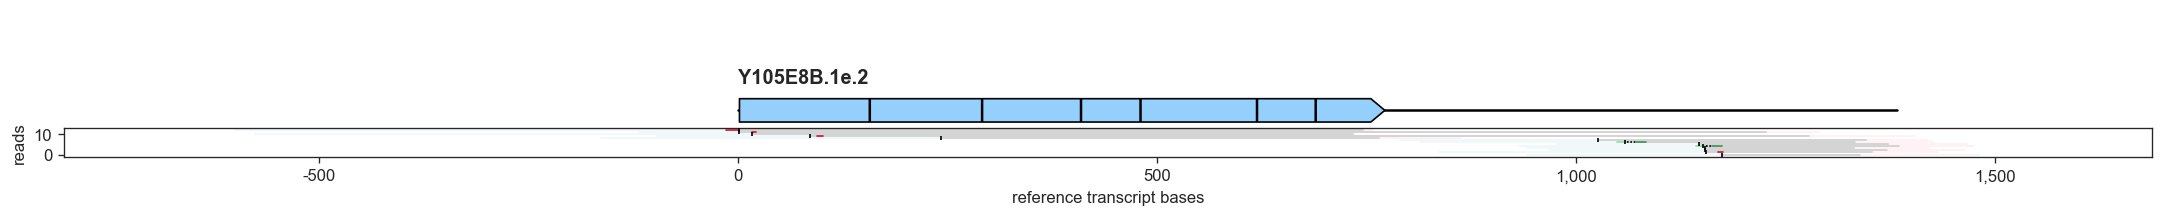

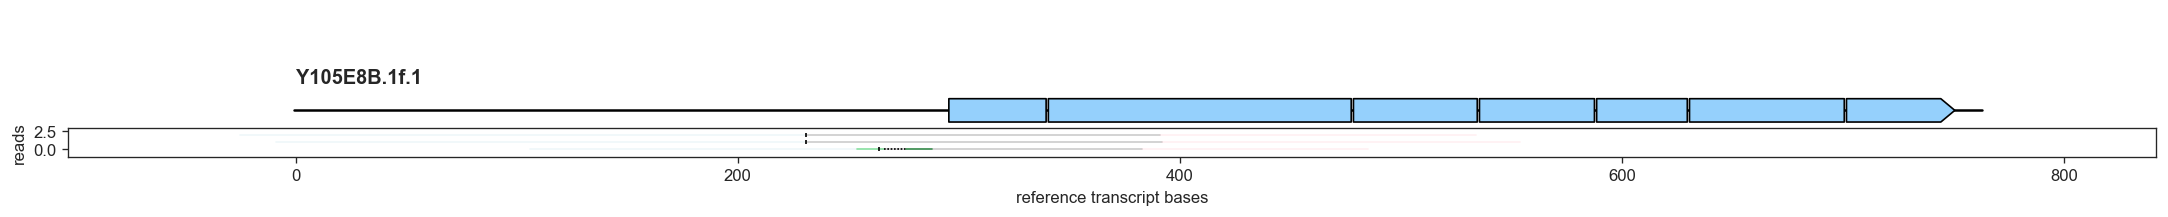

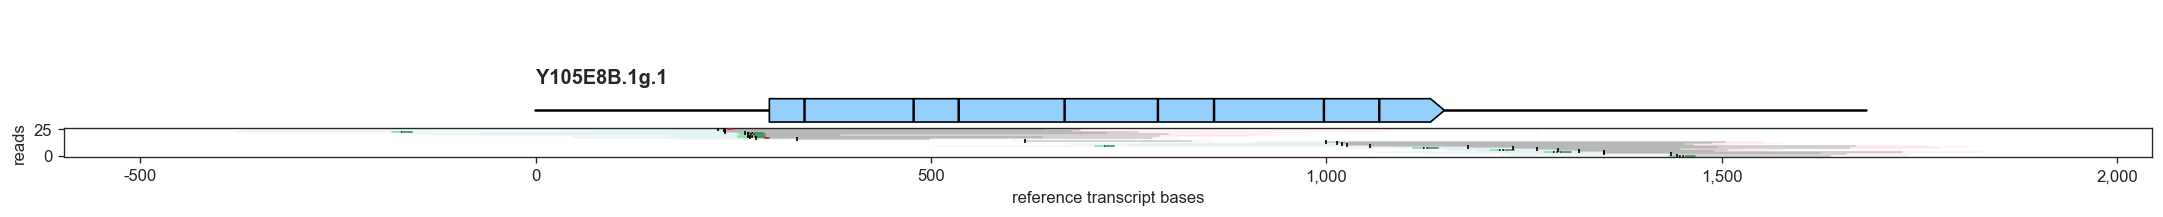

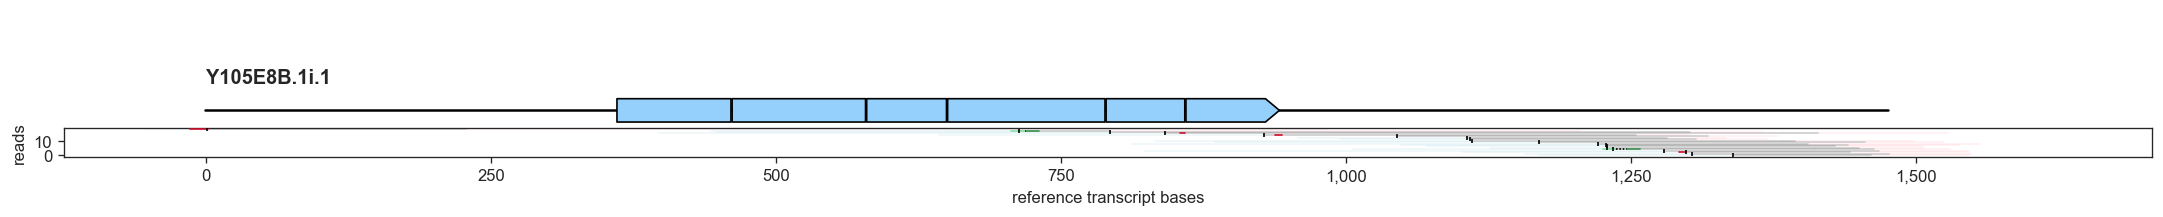

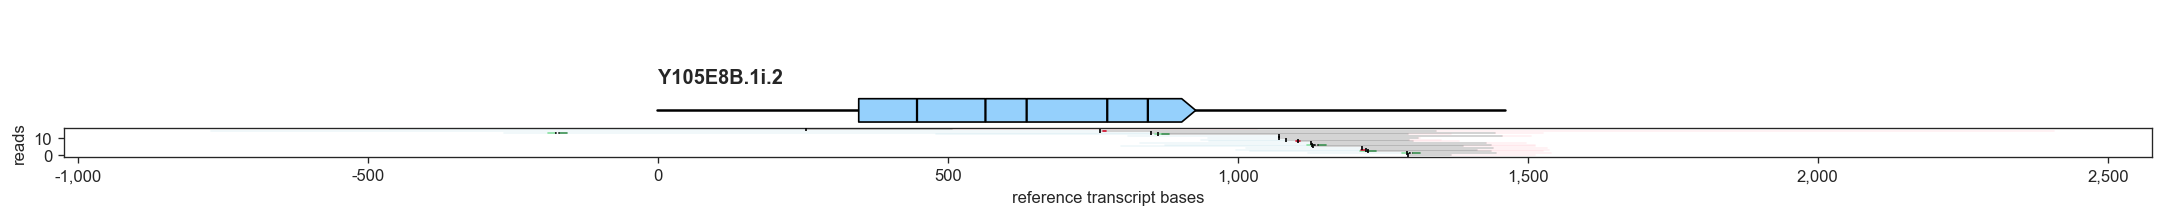

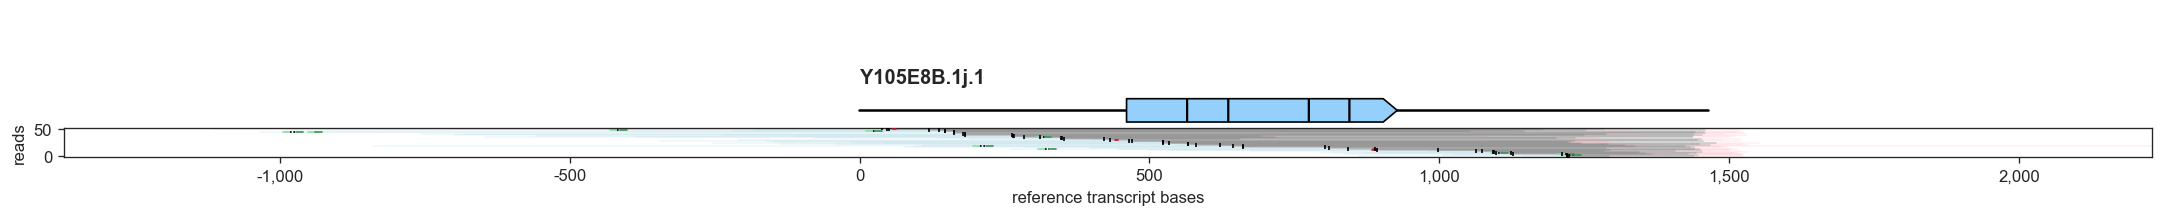

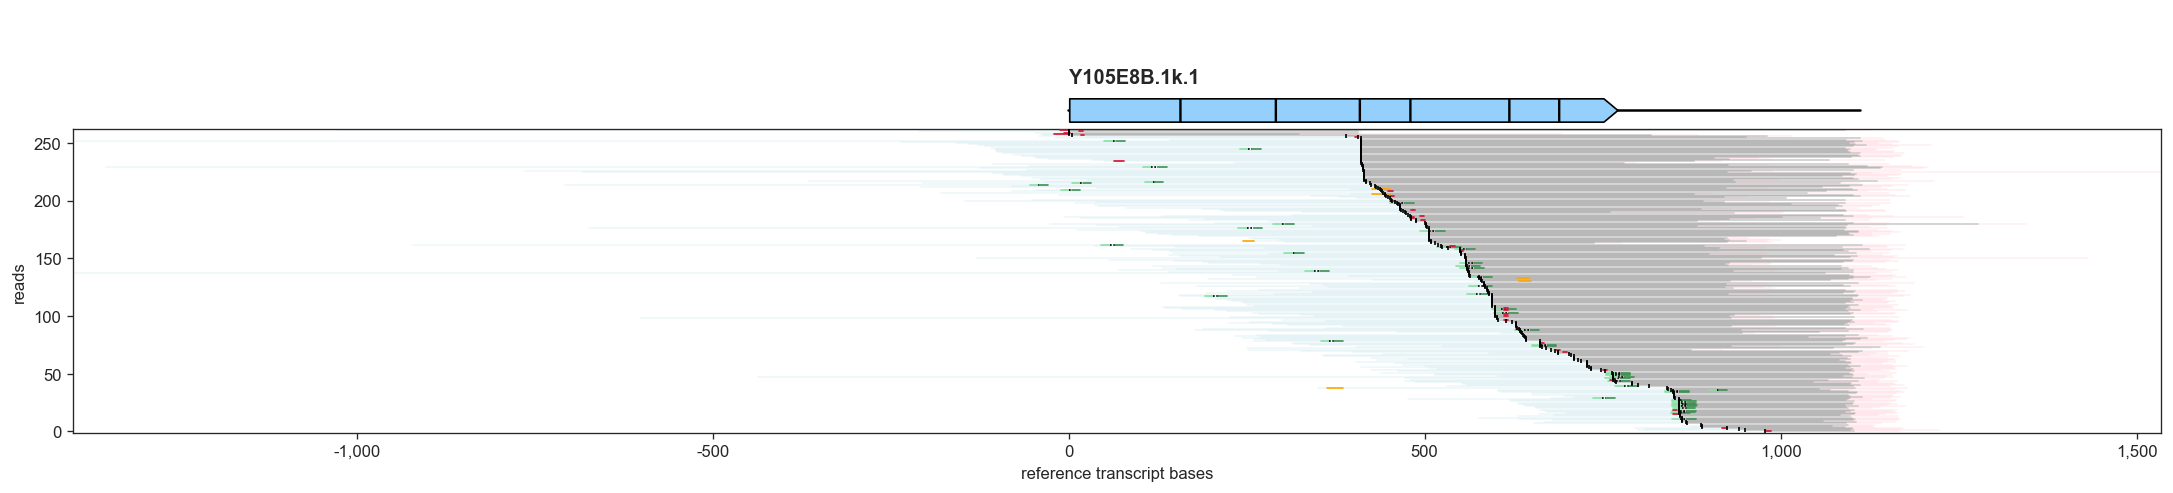

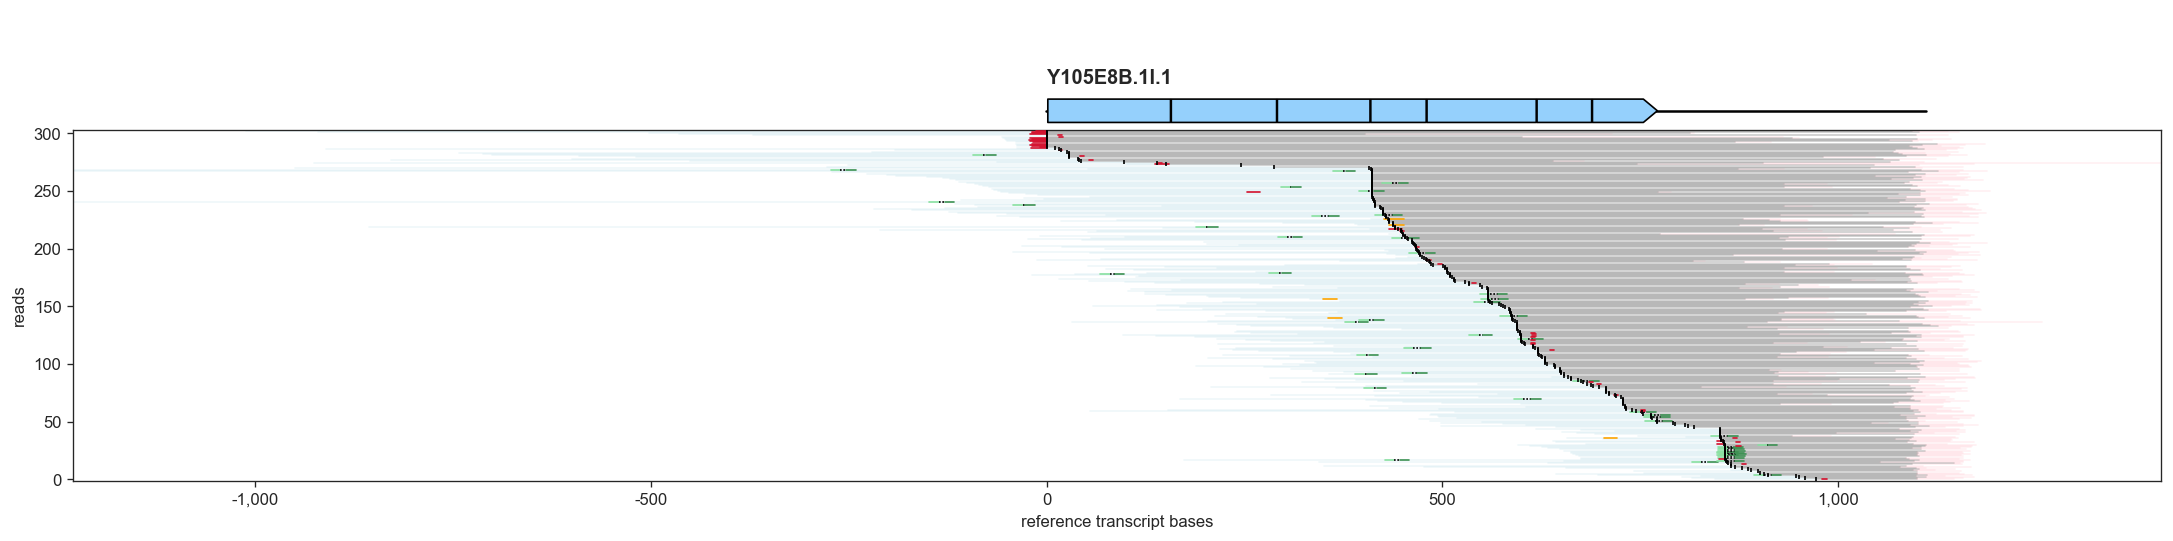

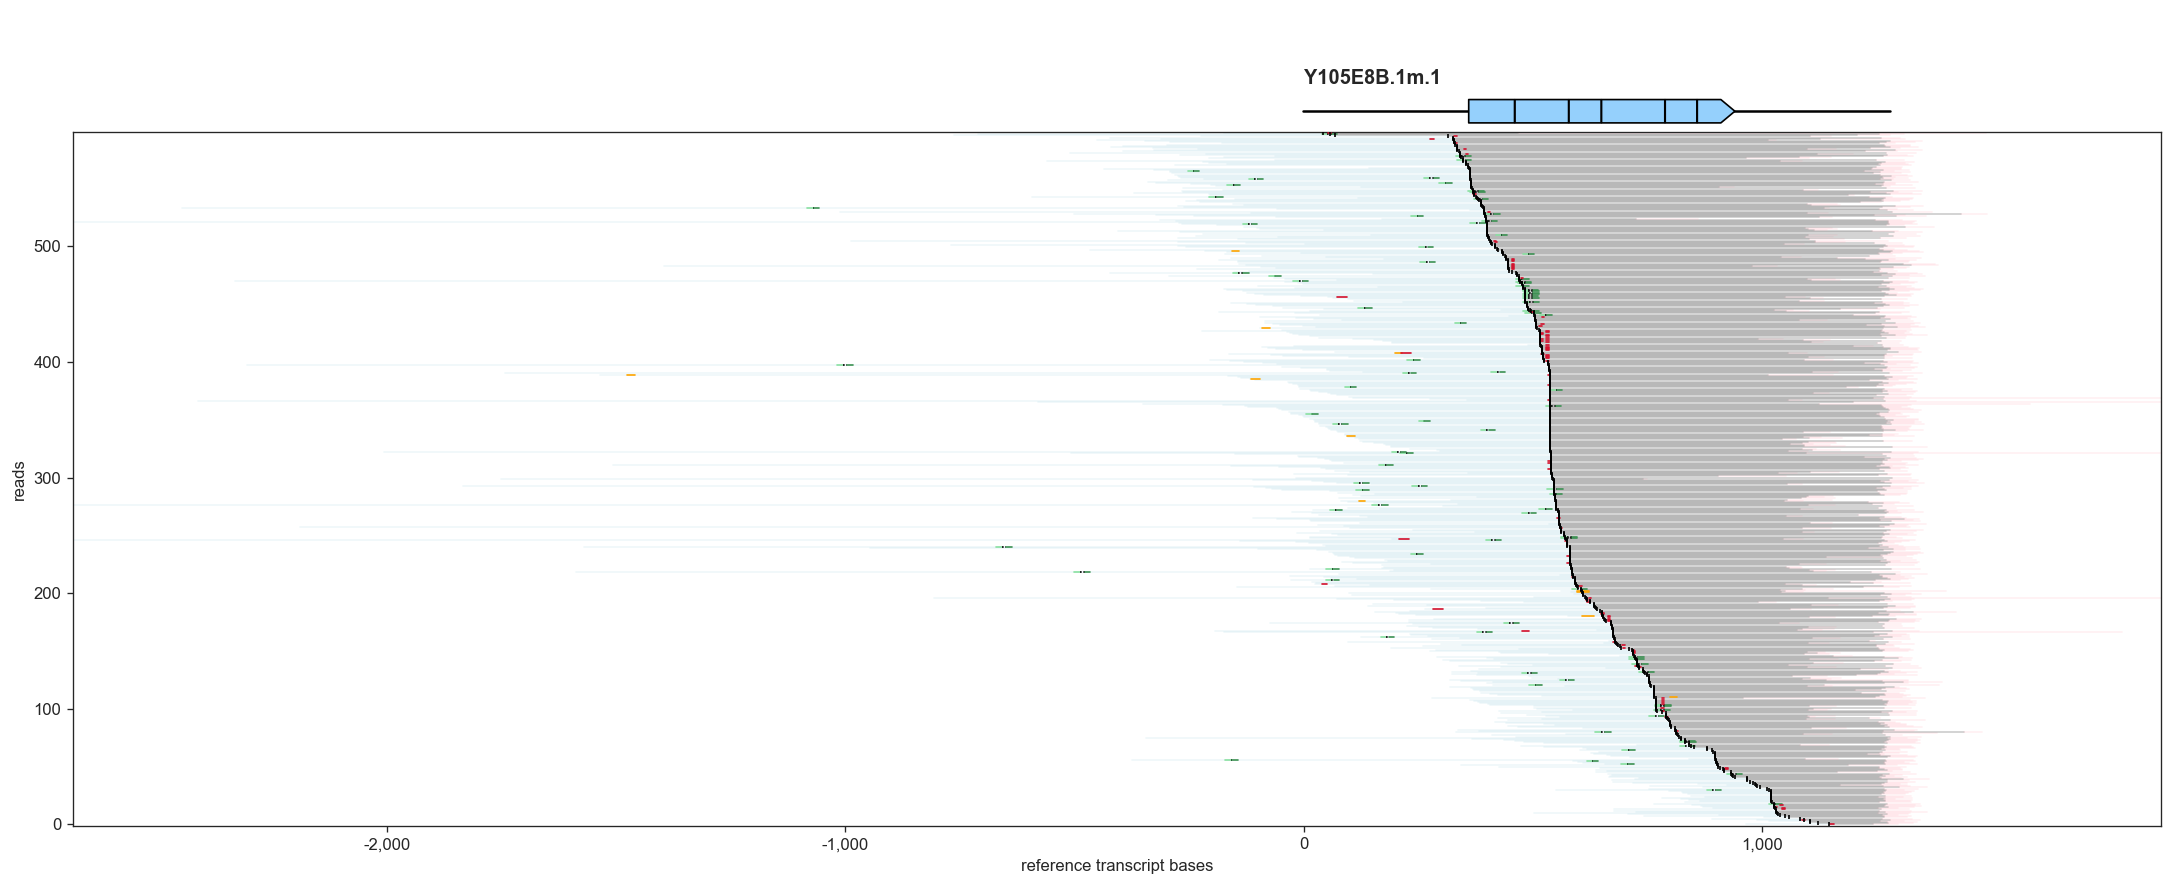

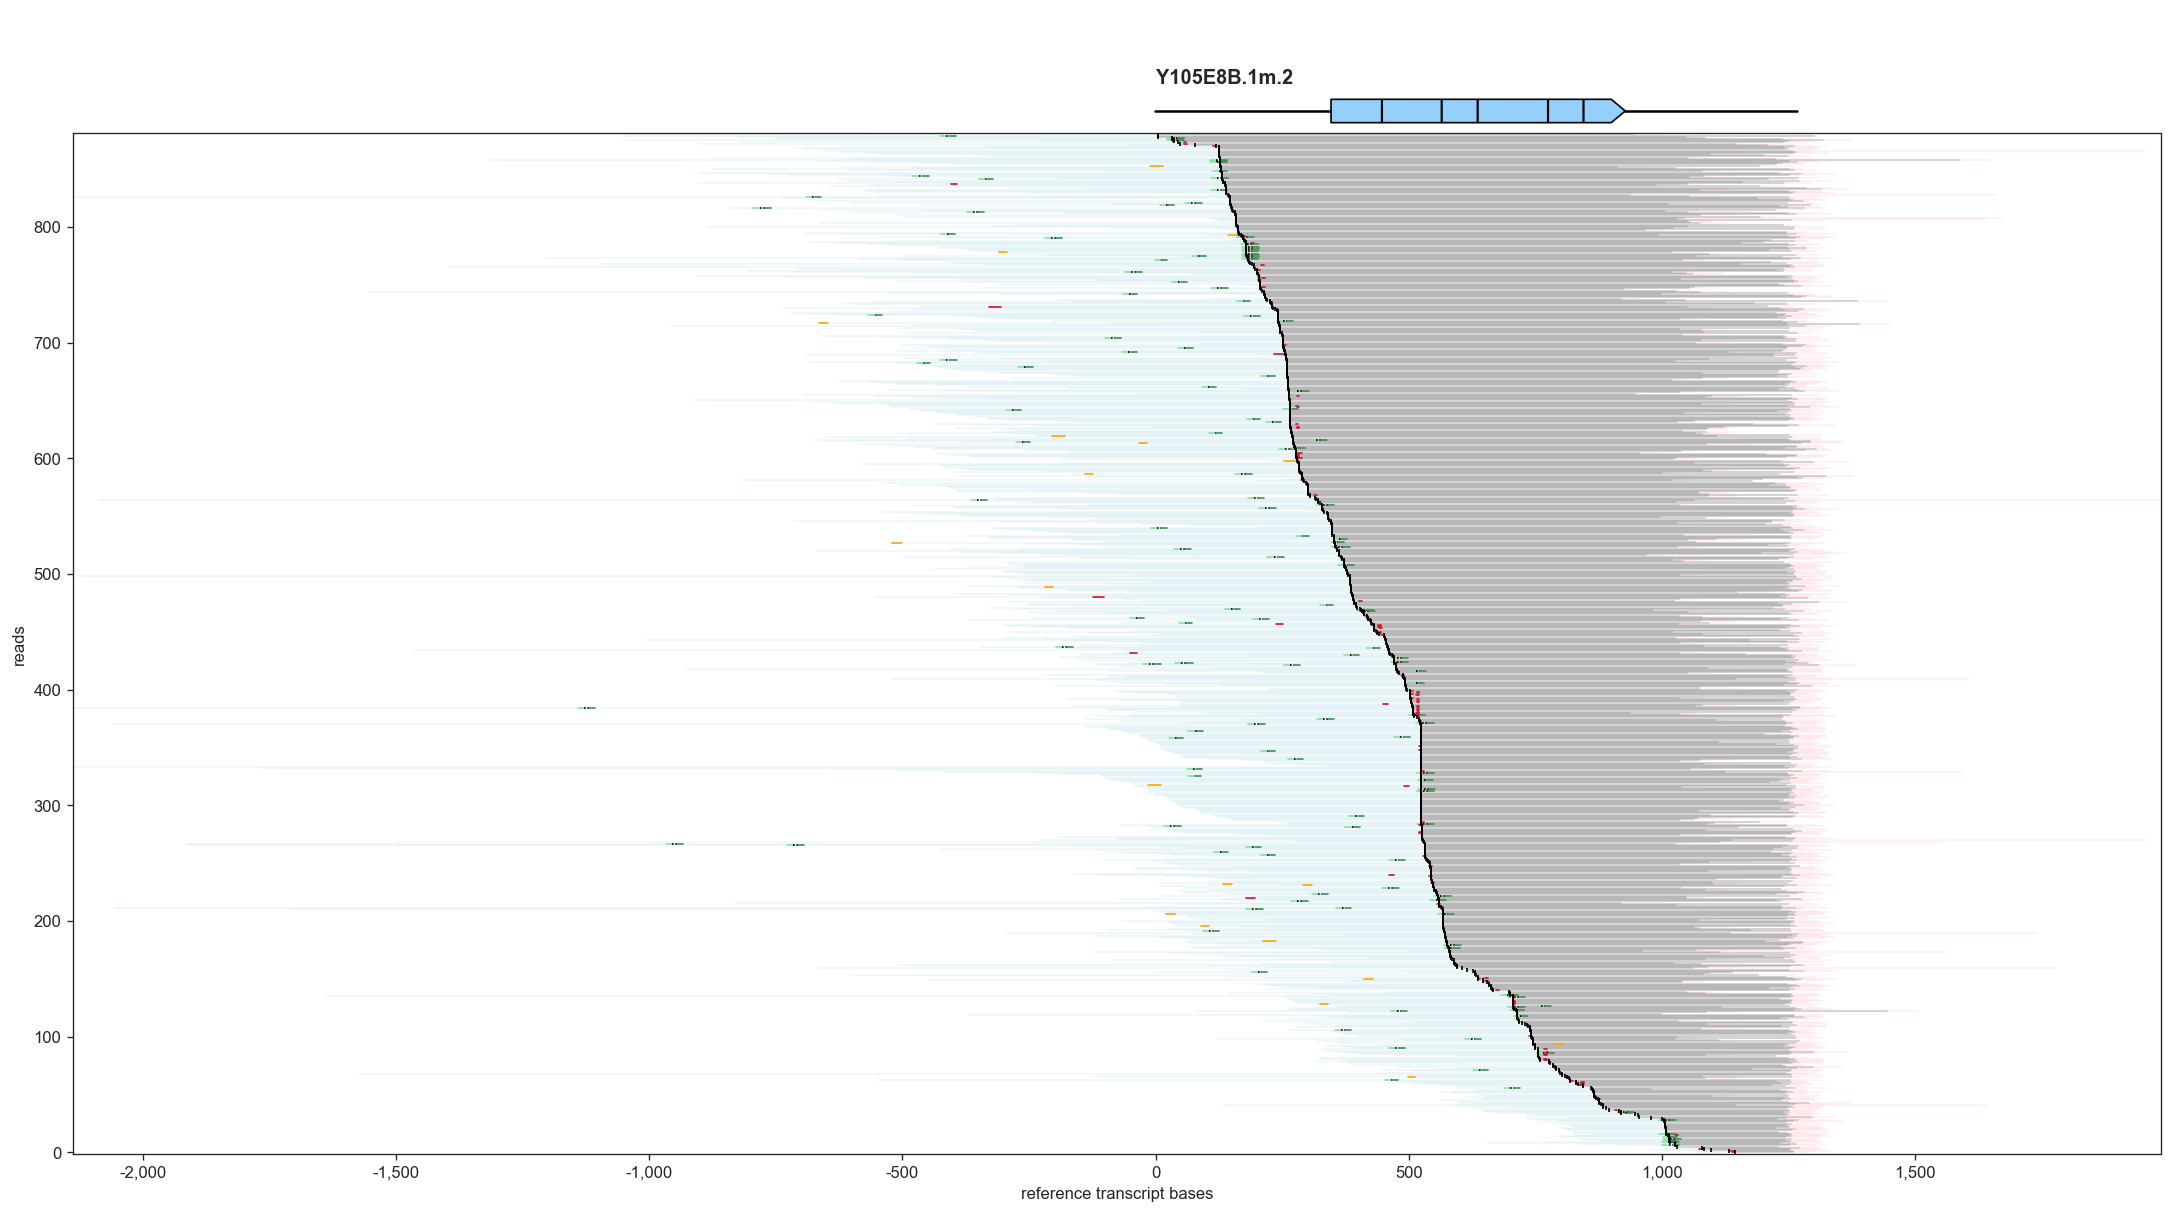

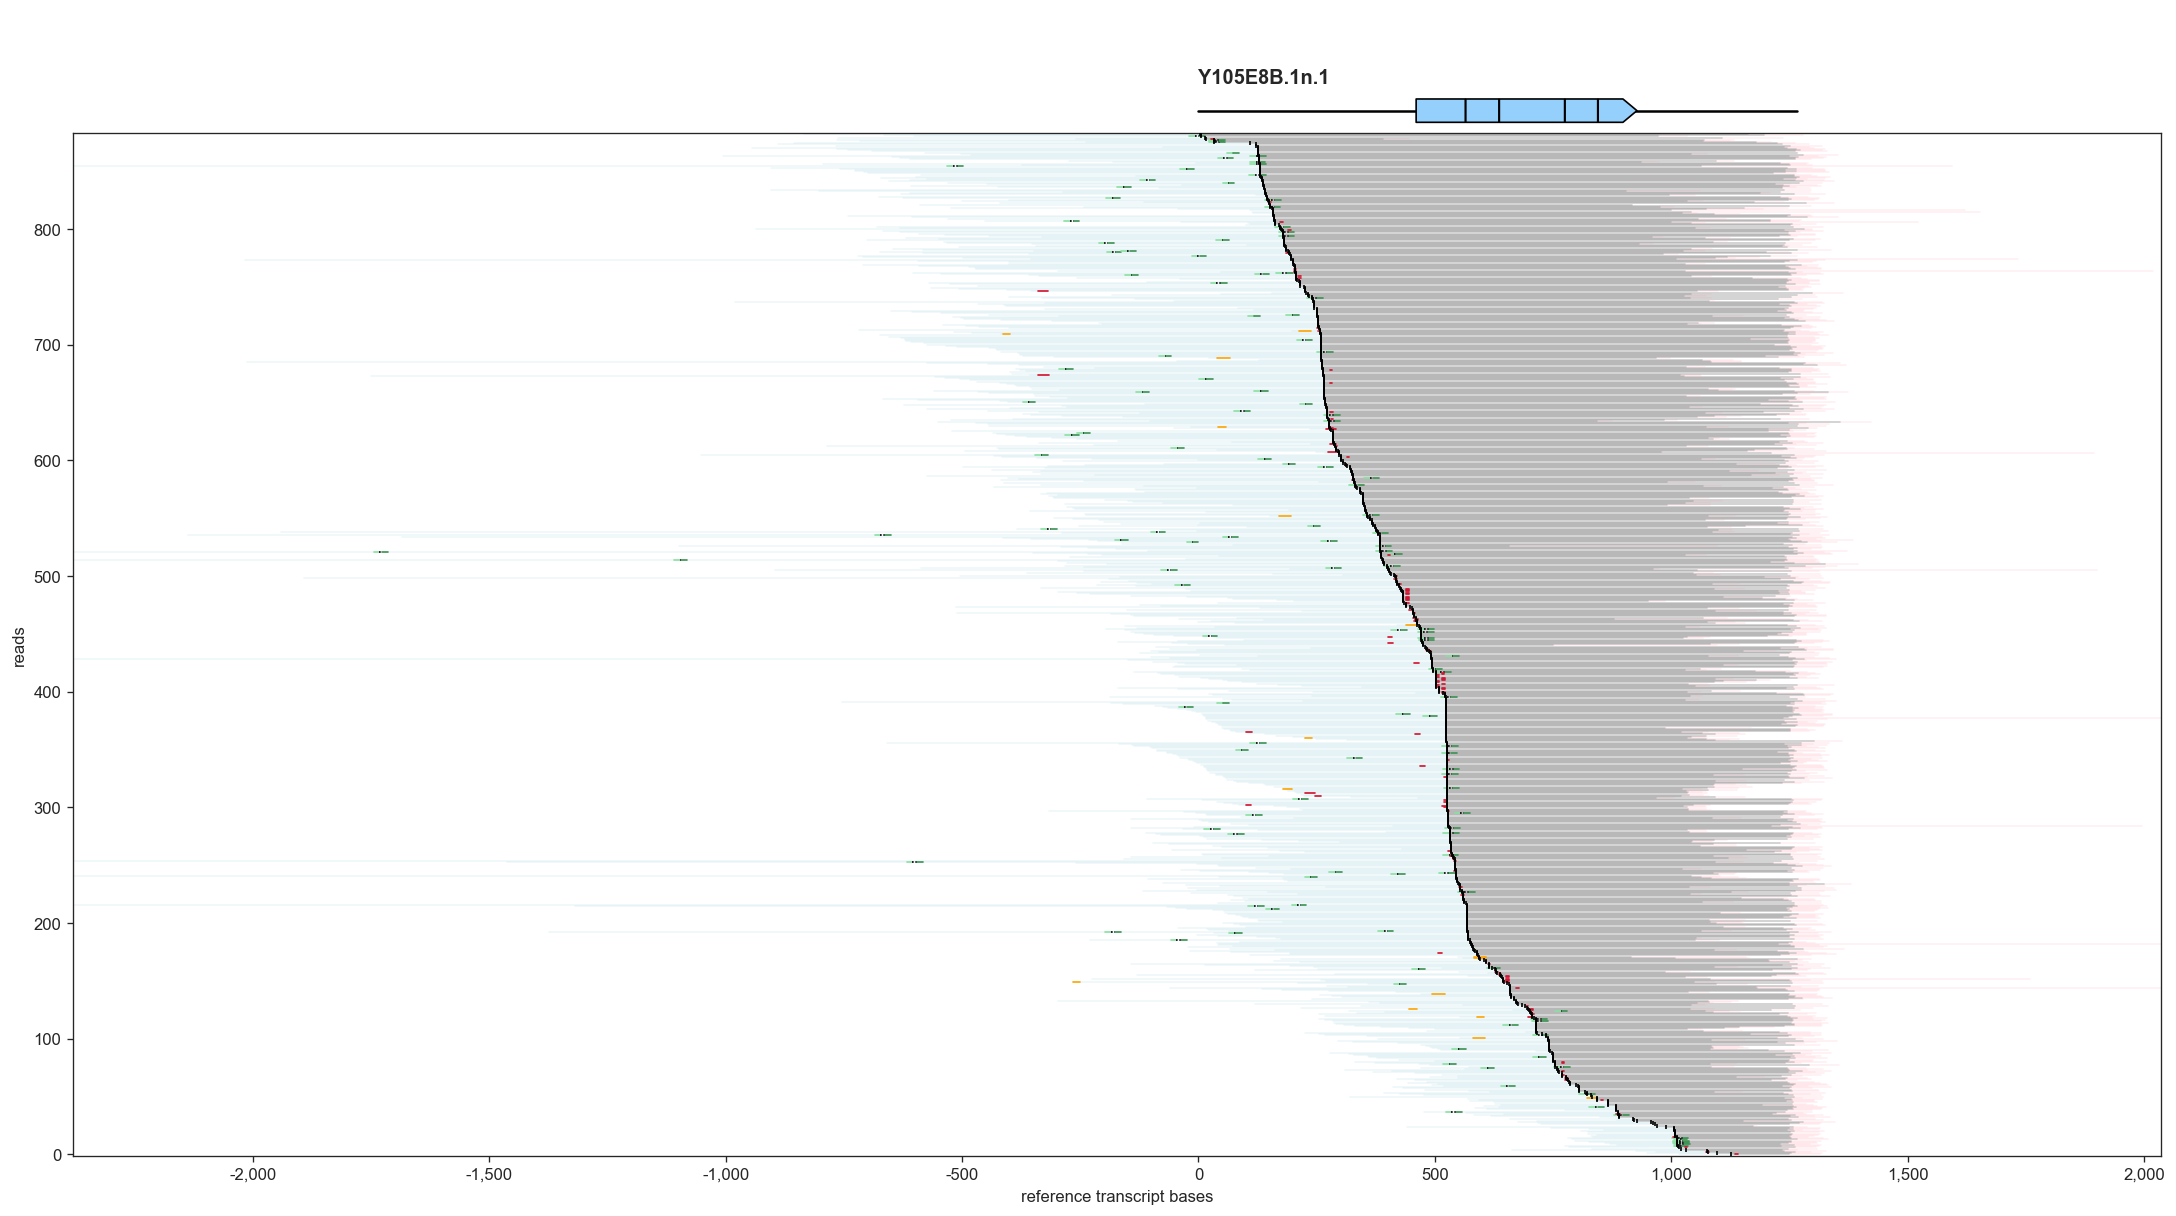

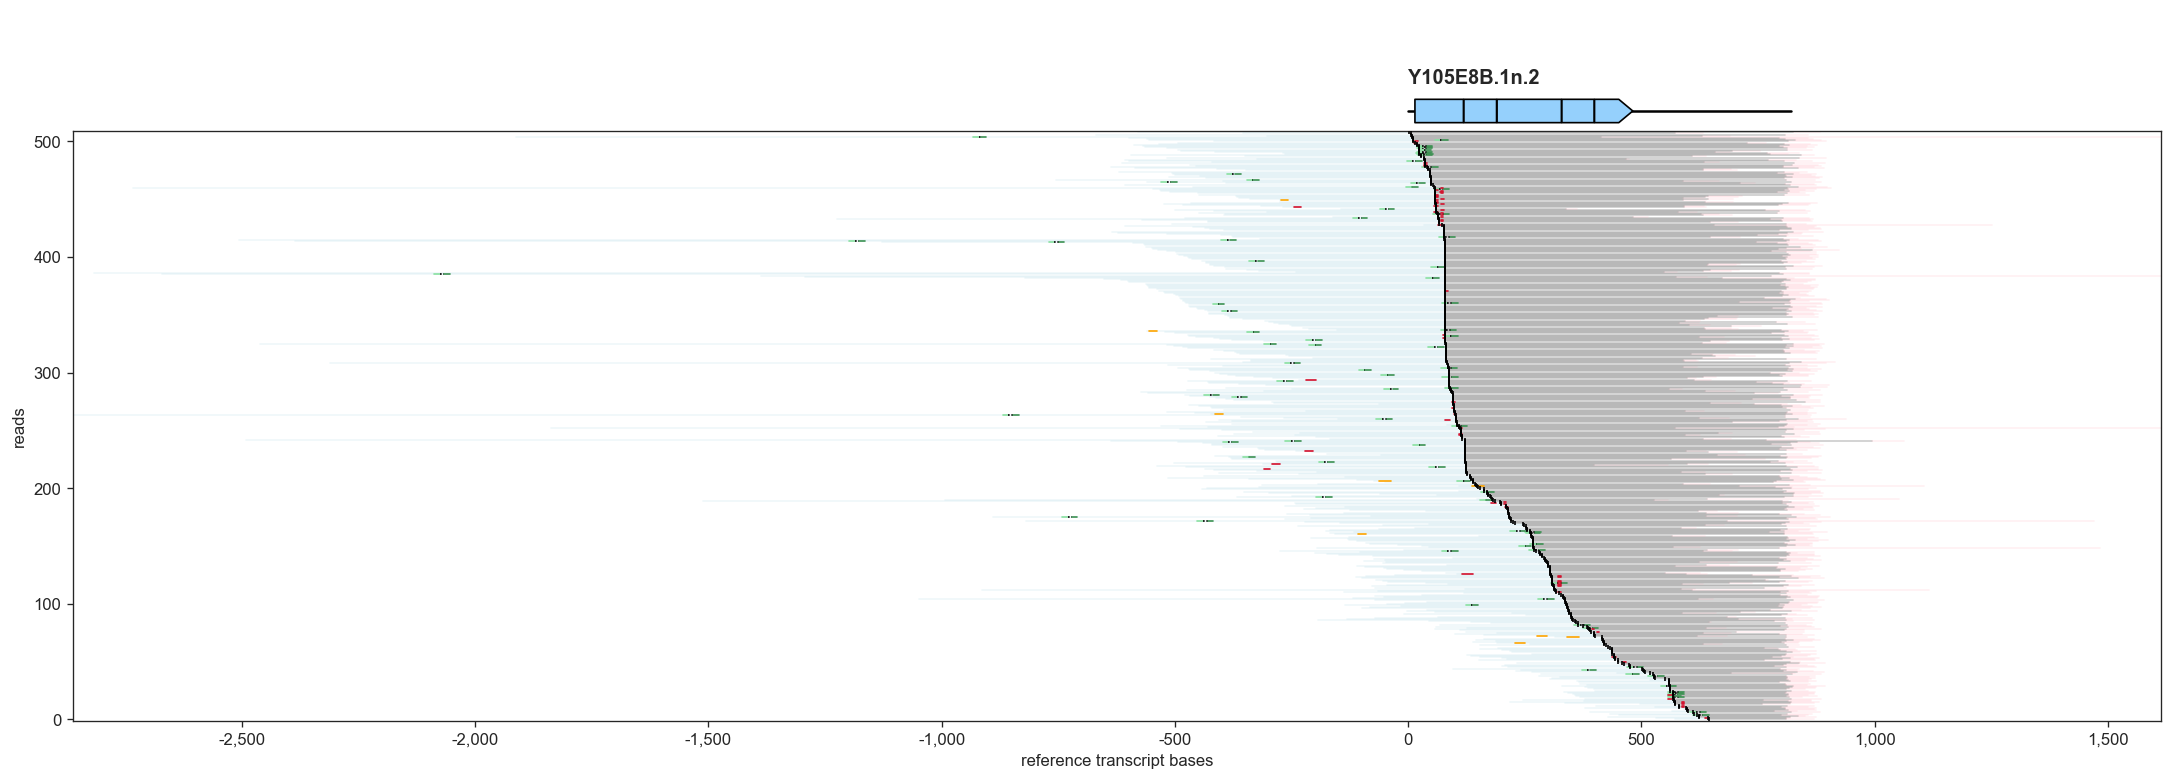

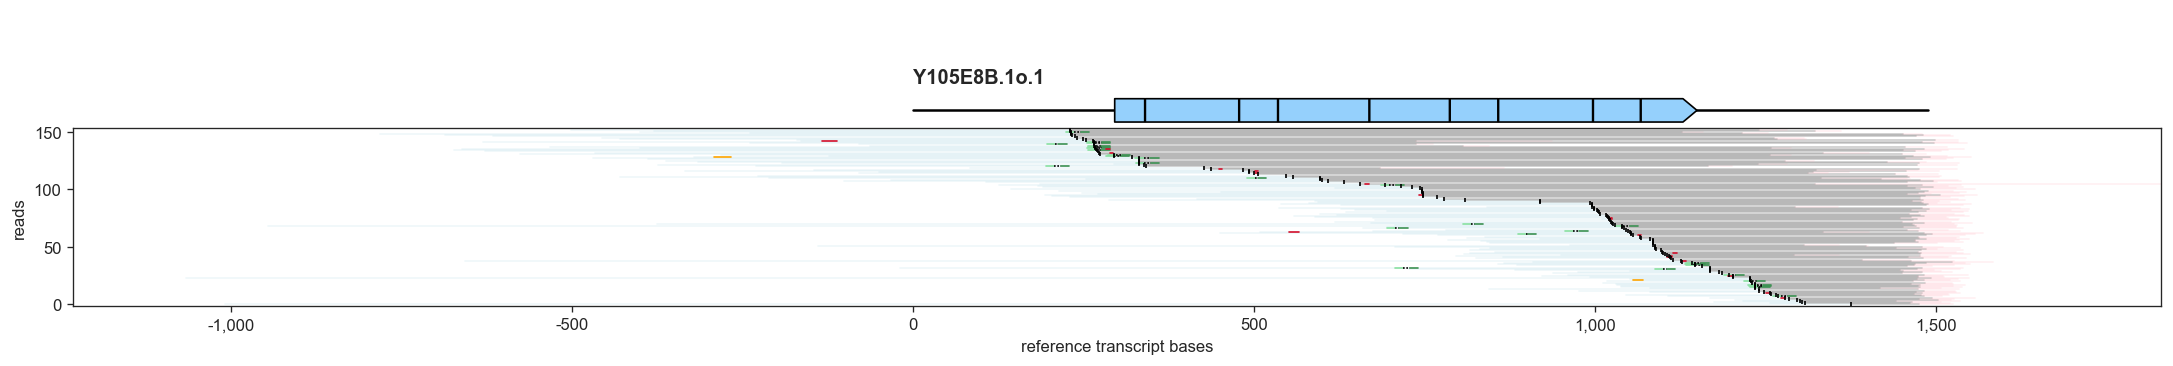

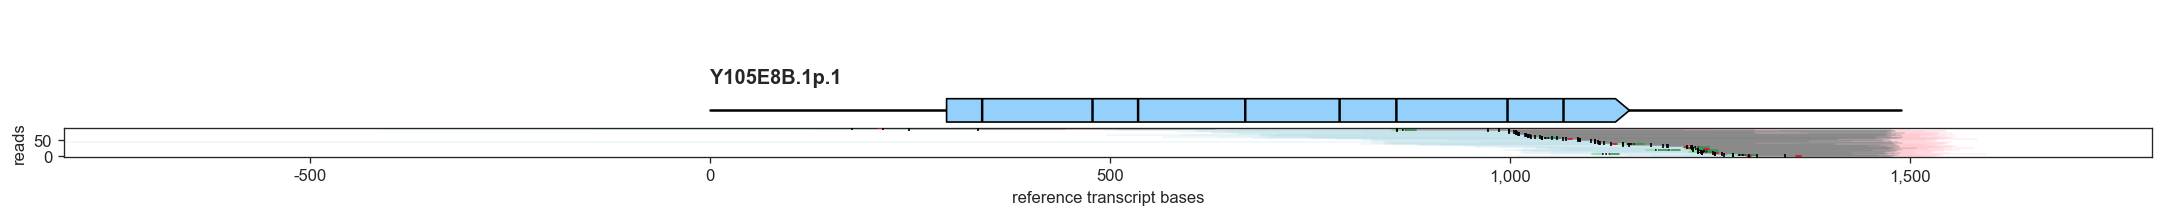

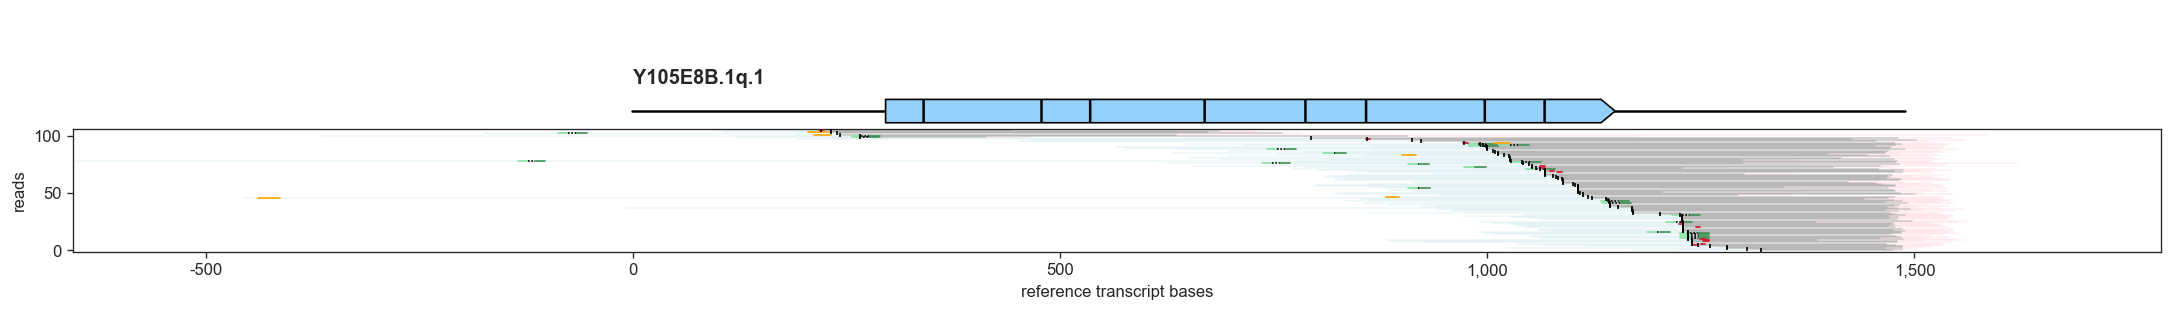

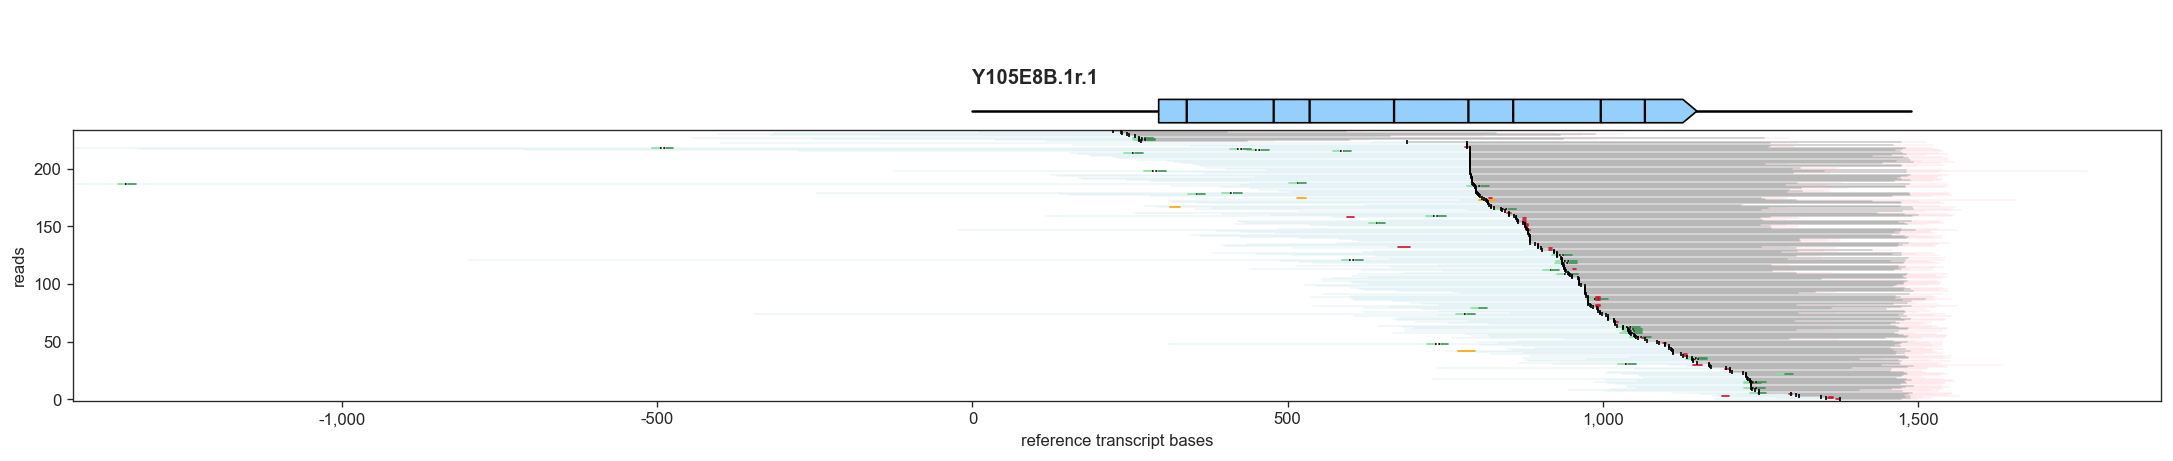

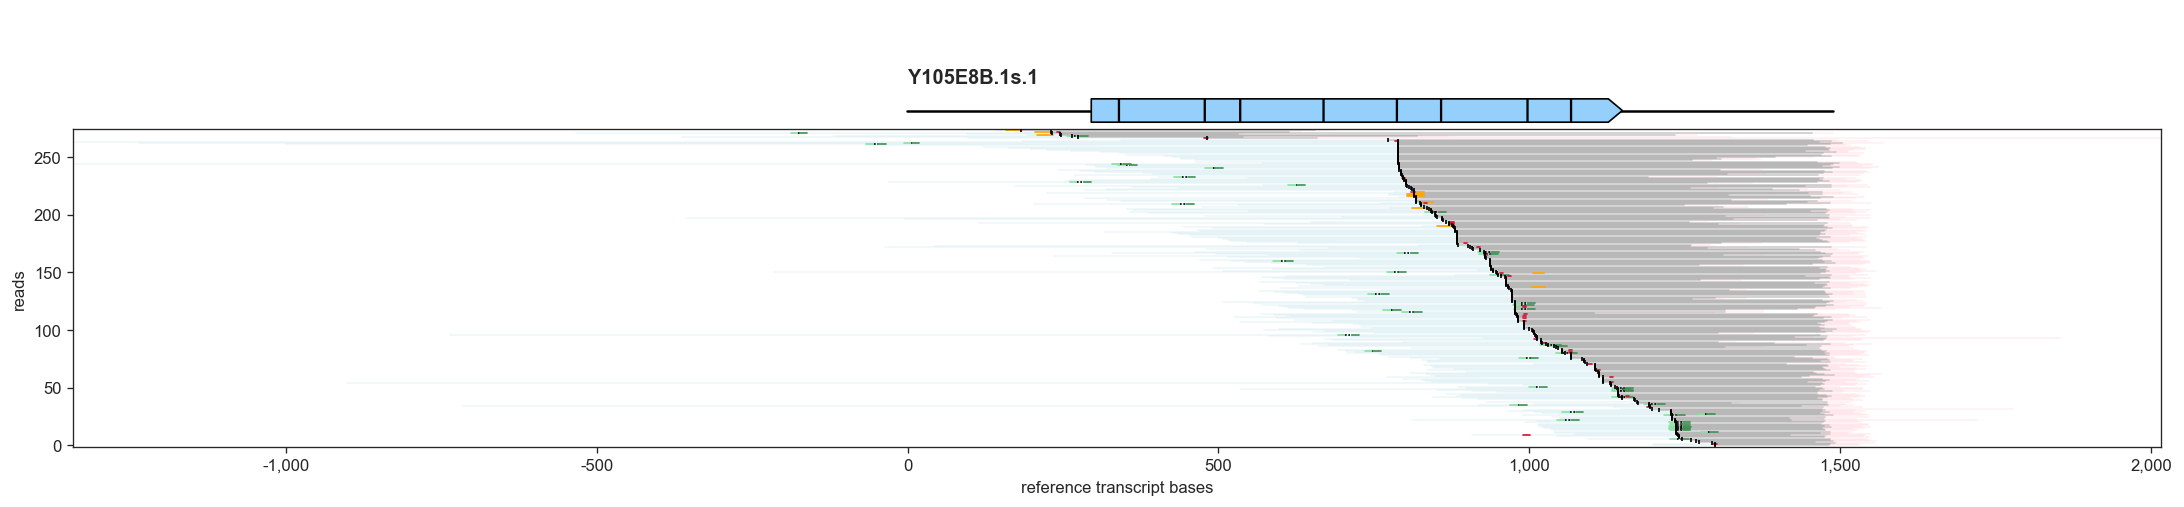

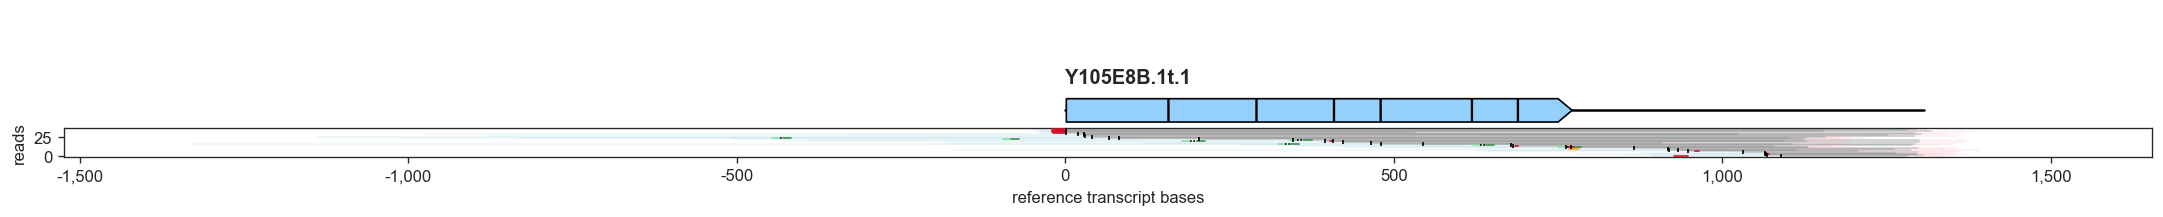

In [14]:
plot_with_isoform_structure(gene='Y105E8B.1', dataframe=dataset, savefig=True)

<font size="4">**Supplementary Figure 7.d:**<br></font>
Expanded representation of read features identified for each annotated gene isoform.